<a href="https://colab.research.google.com/github/SiMori92/reddit-NLP/blob/main/Inspection_%26_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Content
Data: 29 Oct 2023
number of sample: 19

- Pre 1: Load libraries
- Pre 2: Load data
  - split training set & testing set

1. Data inspection
  1. meta features
  2. Embeddings
    - Load the 2 popular embedding
    - Embeddings Coverage
    - generating the oov -> then check coverage
  3. N-gram analysis (for sentiment analysis)
    - uni
    - bi
    - tri
  4. (need further data)sentiment distribution
  5. (need further data)topic distribution (topic modeling algorithms (e.g., LDA, NMF))

2. Data processing
  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  5. Inspection after processing

3. Features engineering
  1. Sentiment analysis on top n-grams
      - option 1 - NLTK
      - option 2 - Textblob
      - option 3 - specific for financial terms
  2. Time-series

    
4. Prepare the Training dataset
  1. check for Duplicated labeled records
  2. normalise

## Pre 1: Load libraries

In [1]:
# import library

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
import string

import gc
import operator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# popular Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

!pip install bert-tensorflow
from bert import tokenization

from collections import defaultdict

import seaborn as sns

from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

## Pre 2: Load data

In [4]:
#load excel
consol_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CUSCS/CUSCS - final project/data/consol_Reddit_df_unique_Oct22-Jun23.csv", index_col=0)
consol_df

date                                           comments
0    2022-07-13  This week's [Earnings Thread](https://www.redd...
1    2022-07-14  This week's [Earnings Thread](https://www.redd...
2    2022-07-15  Cashed out up 56k today. Now cuddled up watchi...
3    2022-07-19  This week's [Earnings Thread](https://www.redd...
4    2022-07-20  If 2008 was the Great Recession\n\nThen 2022 i...
..          ...                                                ...
187  2023-06-26  I was holding puts over the weekend. Thought f...
188  2023-06-27  I watched TSLA rise for 3 months. 3 months. 3 ...
189  2023-06-28  Trades when I 15x: $300 invested\n\nTrades whe...
190  2023-06-29  That closing green candle was like a 5 trillio...
191  2023-06-30  -July 4th on deck\n\n-Historic June rally\n\n-...

[192 rows x 2 columns]

In [9]:
train_df = consol_df[:10]
test_df = consol_df[10:20]

In [6]:
# combine df
'''
consol_df = pd.concat([part1_df, part2_df], ignore_index=True)
consol_df
'''

'\nconsol_df = pd.concat([part1_df, part2_df], ignore_index=True)\nconsol_df\n'

In [7]:
# split training set & testing set

train_df = consol_df[:150].reset_index()

test_df = consol_df[501:191].reset_index()

# test_df = pd.concat([consol_df.iloc[:40], consol_df.iloc[111:]]).reset_index()

train_df

index        date                                           comments
0        0  2022-07-13  This week's [Earnings Thread](https://www.redd...
1        1  2022-07-14  This week's [Earnings Thread](https://www.redd...
2        2  2022-07-15  Cashed out up 56k today. Now cuddled up watchi...
3        3  2022-07-19  This week's [Earnings Thread](https://www.redd...
4        4  2022-07-20  If 2008 was the Great Recession\n\nThen 2022 i...
..     ...         ...                                                ...
145    145  2023-04-24  #And my $25K in towel stock are all gone…… jus...
146    146  2023-04-25  Phone is glitched, FRC not showing $110 If I d...
147    147  2023-04-26  6 months ago, I couldn’t even afford to get gu...
148    148  2023-04-27  META up 135% since Cramer cried on live TV and...
149    149  2023-04-28  A trillion dollar company up 10% in after hour...

[150 rows x 3 columns]

## 1. Data inspection

1. Meta features
2. Embedding coverage
3. N-gram analysis (for sentiment analysis)
  - uni
  - bi
  - tri
4. Sentiment distribution
5. Topic distribution (topic modeling algorithms (e.g., LDA, NMF))

##1.1. Meta Features (understand the structure)

In [10]:
# 2. Meta Features (understand the structure between training & test dataset)

METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
               'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# word_count
train_df['word_count'] = train_df['comments'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['comments'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['comments'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['comments'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['comments'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['comments'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['comments'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['comments'].apply(lambda x: len([c for c in str(x) if c == '@']))


<ipython-input-10-867f592c12a6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['word_count'] = train_df['comments'].apply(lambda x: len(str(x).split()))
<ipython-input-10-867f592c12a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['unique_word_count'] = train_df['comments'].apply(lambda x: len(set(str(x).split())))
<ipython-input-10-867f592c12a6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [11]:
train_df.describe()

word_count  unique_word_count  stop_word_count   url_count  \
count      10.000000          10.000000         10.00000   10.000000   
mean   129813.200000       21446.400000      53215.50000  202.200000   
std     12876.918496        1182.775474       5013.28141   29.574013   
min     98712.000000       18254.000000      41280.00000  153.000000   
25%    128640.000000       21338.500000      52588.75000  184.750000   
50%    134093.000000       21800.000000      54769.50000  201.500000   
75%    138390.000000       21969.500000      56165.25000  222.000000   
max    140046.000000       22343.000000      58161.00000  254.000000   

       mean_word_length     char_count  punctuation_count  hashtag_count  \
count         10.000000      10.000000          10.000000      10.000000   
mean           4.735477  747205.800000       34989.800000     157.800000   
std            0.029460   75289.214467        4096.446097      38.421059   
min            4.690544  563725.000000       24583.000000      86.000000   
25%            4.714231  741796.500000       34931.750000     141.000000   
50%            4.742648  772041.500000       35865.000000     158.000000   
75%            4.755132  796206.500000       37004.500000     180.000000   
max            4.771532  811301.000000       39267.000000     222.000000   

       mention_count  
count      10.000000  
mean       89.400000  
std        18.191573  
min        51.000000  
25%        80.250000  
50%        90.000000  
75%       105.000000  
max       111.000000

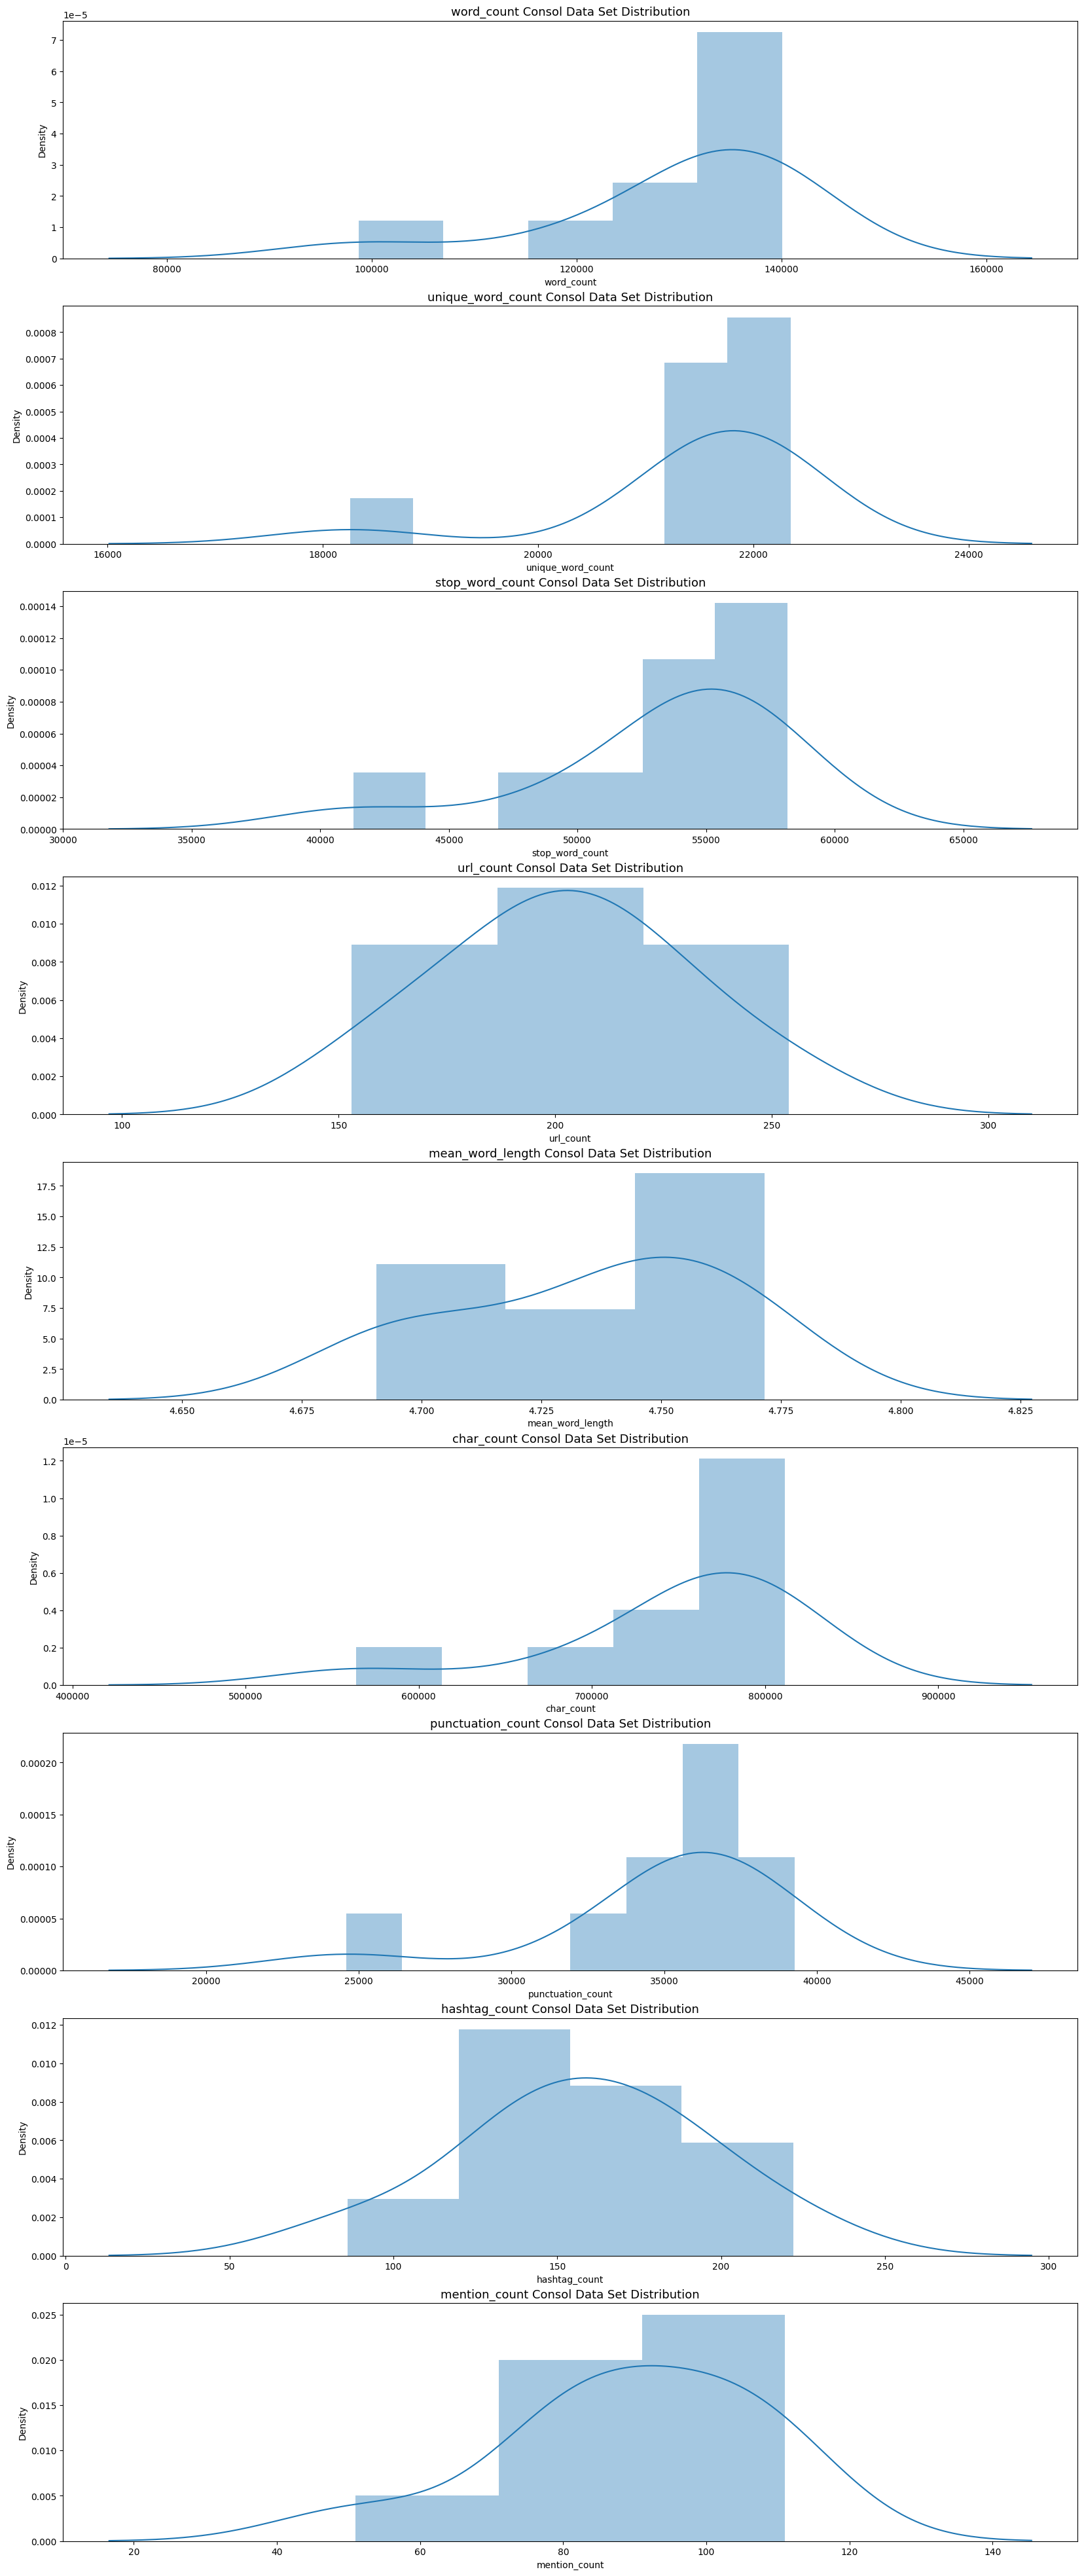

In [12]:
import warnings
warnings.filterwarnings("ignore")

# visualisation of meta features

fig, axes = plt.subplots(ncols=1, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):

    sns.distplot(train_df[feature], label='Consol', ax=axes[i])

    axes[i].set_title(f'{feature} Consol Data Set Distribution', fontsize=13)

plt.show()

## 1.2. Embeddings coverage

In [13]:
#Load the 2 popular embedding
#glove
#fasttext

fasttext_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/crawl-300d-2M-002-001.pkl', allow_pickle=True)
glove_embeddings = np.load('/content/drive/MyDrive/Colab Notebooks/Embeddings/glove.840B.300d-001-002.pkl', allow_pickle=True)

In [14]:
glove_embeddings

{',': array([-0.082752 ,  0.67204  , -0.14987  , -0.064983 ,  0.056491 ,
         0.40228  ,  0.0027747, -0.3311   , -0.30691  ,  2.0817   ,
         0.031819 ,  0.013643 ,  0.30265  ,  0.0071297, -0.5819   ,
        -0.2774   , -0.062254 ,  1.1451   , -0.24232  ,  0.1235   ,
        -0.12243  ,  0.33152  , -0.006162 , -0.30541  , -0.13057  ,
        -0.054601 ,  0.037083 , -0.070552 ,  0.5893   , -0.30385  ,
         0.2898   , -0.14653  , -0.27052  ,  0.37161  ,  0.32031  ,
        -0.29125  ,  0.0052483, -0.13212  , -0.052736 ,  0.087349 ,
        -0.26668  , -0.16897  ,  0.015162 , -0.0083746, -0.14871  ,
         0.23413  , -0.20719  , -0.091386 ,  0.40075  , -0.17223  ,
         0.18145  ,  0.37586  , -0.28682  ,  0.37289  , -0.16185  ,
         0.18008  ,  0.3032   , -0.13216  ,  0.18352  ,  0.095759 ,
         0.094916 ,  0.008289 ,  0.11761  ,  0.34046  ,  0.03677  ,
        -0.29077  ,  0.058303 , -0.027814 ,  0.082941 ,  0.1862   ,
        -0.031494 ,  0.27985  , -0.074412 ,

In [15]:
# Embeddings Coverage

# break the comments into words
# vocab is the unique words in the text data
def build_vocab(X):

    comments = X.apply(lambda s: s.split()).values
    vocab = {}

    for comment in comments:
        for word in comment:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab


def check_embeddings_coverage(X, embeddings):

    vocab = build_vocab(X)

    covered = {}
    oov = {}
    n_covered = 0
    n_oov = 0

    for word in vocab:
        try:
            covered[word] = embeddings[word] #函式嘗試將當前單詞加入到covered中，如果該單詞可以在embeddings中找到對應的向量
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word] # 否則，函式將當前單詞加入到oov中，表示該單詞未被涵蓋
            n_oov += vocab[word]

    #calculate the coverage
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))

    # 函式將oov字典按照值（即未涵蓋的單詞數量）進行排序，並以元祖列表的形式返回
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

consol_glove_oov, consol_glove_vocab_coverage, consol_glove_text_coverage = check_embeddings_coverage(train_df['comments'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_glove_vocab_coverage, consol_glove_text_coverage))

consol_fasttext_oov, consol_fasttext_vocab_coverage, consol_fasttext_text_coverage = check_embeddings_coverage(train_df['comments'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Consol Set'.format(consol_fasttext_vocab_coverage, consol_fasttext_text_coverage))

GloVe Embeddings cover 44.70% of vocabulary and 87.27% of text in Consol Set
FastText Embeddings cover 48.36% of vocabulary and 89.42% of text in Consol Set


In [16]:
# generating the oov
# The purpose of generating Out-of-Vocabulary (OOV) embeddings using FastText is to provide vector representations
# - for words that are not present in the original vocabulary of the pre-trained FastText model.
# combination of character n-grams, which allows it to
# - capture the meaning of words even if they are out-of-vocabulary or misspelled.
# OOV words can negatively impact the performance of the model, and having embeddings
# - for these words can help improve the accuracy and robustness of the model.

# lump the 2 oov list as one
mergedlist = consol_glove_oov + consol_fasttext_oov

# 將新列表轉換為集合，這將刪除重複的元素
unique_set = set(mergedlist)

# 將集合轉換為列表，以便返回
total_oov = list(unique_set)
df_total_oov = pd.DataFrame(total_oov, columns = ['oov', 'oov_counts'])

# sort the oov frequency
df_total_oov_sorted = df_total_oov.sort_values(by='oov_counts', ascending=False)

# Reset the index to maintain the original order
df_total_oov_sorted = df_total_oov_sorted.reset_index(drop=True)
df_total_oov_sorted

# save as new CSV
df_total_oov_sorted.to_csv('total_oov.csv')

print(f"The counts of records in Glove OOV list is {len(consol_glove_oov)}")
print(f"The counts of records in Fasttest OOV list is {len(consol_fasttext_oov)}")
print(f"The counts of records in Total OOV list is {len(total_oov)}")


The counts of records in Glove OOV list is 54372
The counts of records in Fasttest OOV list is 50776
The counts of records in Total OOV list is 55566


## 1.3. N-gram analysis (for sentiment analysis)

In [17]:
# 3. Ngrams(rank Ngrams in both labels)
# understand the info of Ngrams
# provide hints on text structure

def generate_ngrams(text, n_gram=1):
    # tokenisation
    # convert to lower case
    # split words based on spaces.
    # filter out empty tokens and stopwords
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]

    # grouping tokens to form n-grams
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    # joins the tokens within each ngram using the ' ' separator and as 1 string
    return [' '.join(ngram) for ngram in ngrams]

# visualisation how long of N-grams
N = 100

# Unigrams
consol_unigrams = defaultdict(int)

for cmt in train_df['comments']:
    for word in generate_ngrams(cmt):
        consol_unigrams[word] += 1

df_unigrams = pd.DataFrame(sorted(consol_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
consol_bigrams = defaultdict(int)

for cmt in train_df['comments']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams[word] += 1

df_bigrams = pd.DataFrame(sorted(consol_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
consol_trigrams = defaultdict(int)

for cmt in train_df['comments']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams[word] += 1

df_trigrams = pd.DataFrame(sorted(consol_trigrams.items(), key=lambda x: x[1])[::-1])

df_unigrams

0     1
0                                                   will  5726
1                                                 market  3603
2                                                   puts  3500
3                                                  going  3281
4                                                     go  2895
...                                                  ...   ...
90997                                        week."\n\ni     1
90998                                            peers\*     1
90999                                          \*giggles     1
91000                                             dataa.     1
91001  thread](https://www.reddit.com/r/wallstreetbet...     1

[91002 rows x 2 columns]

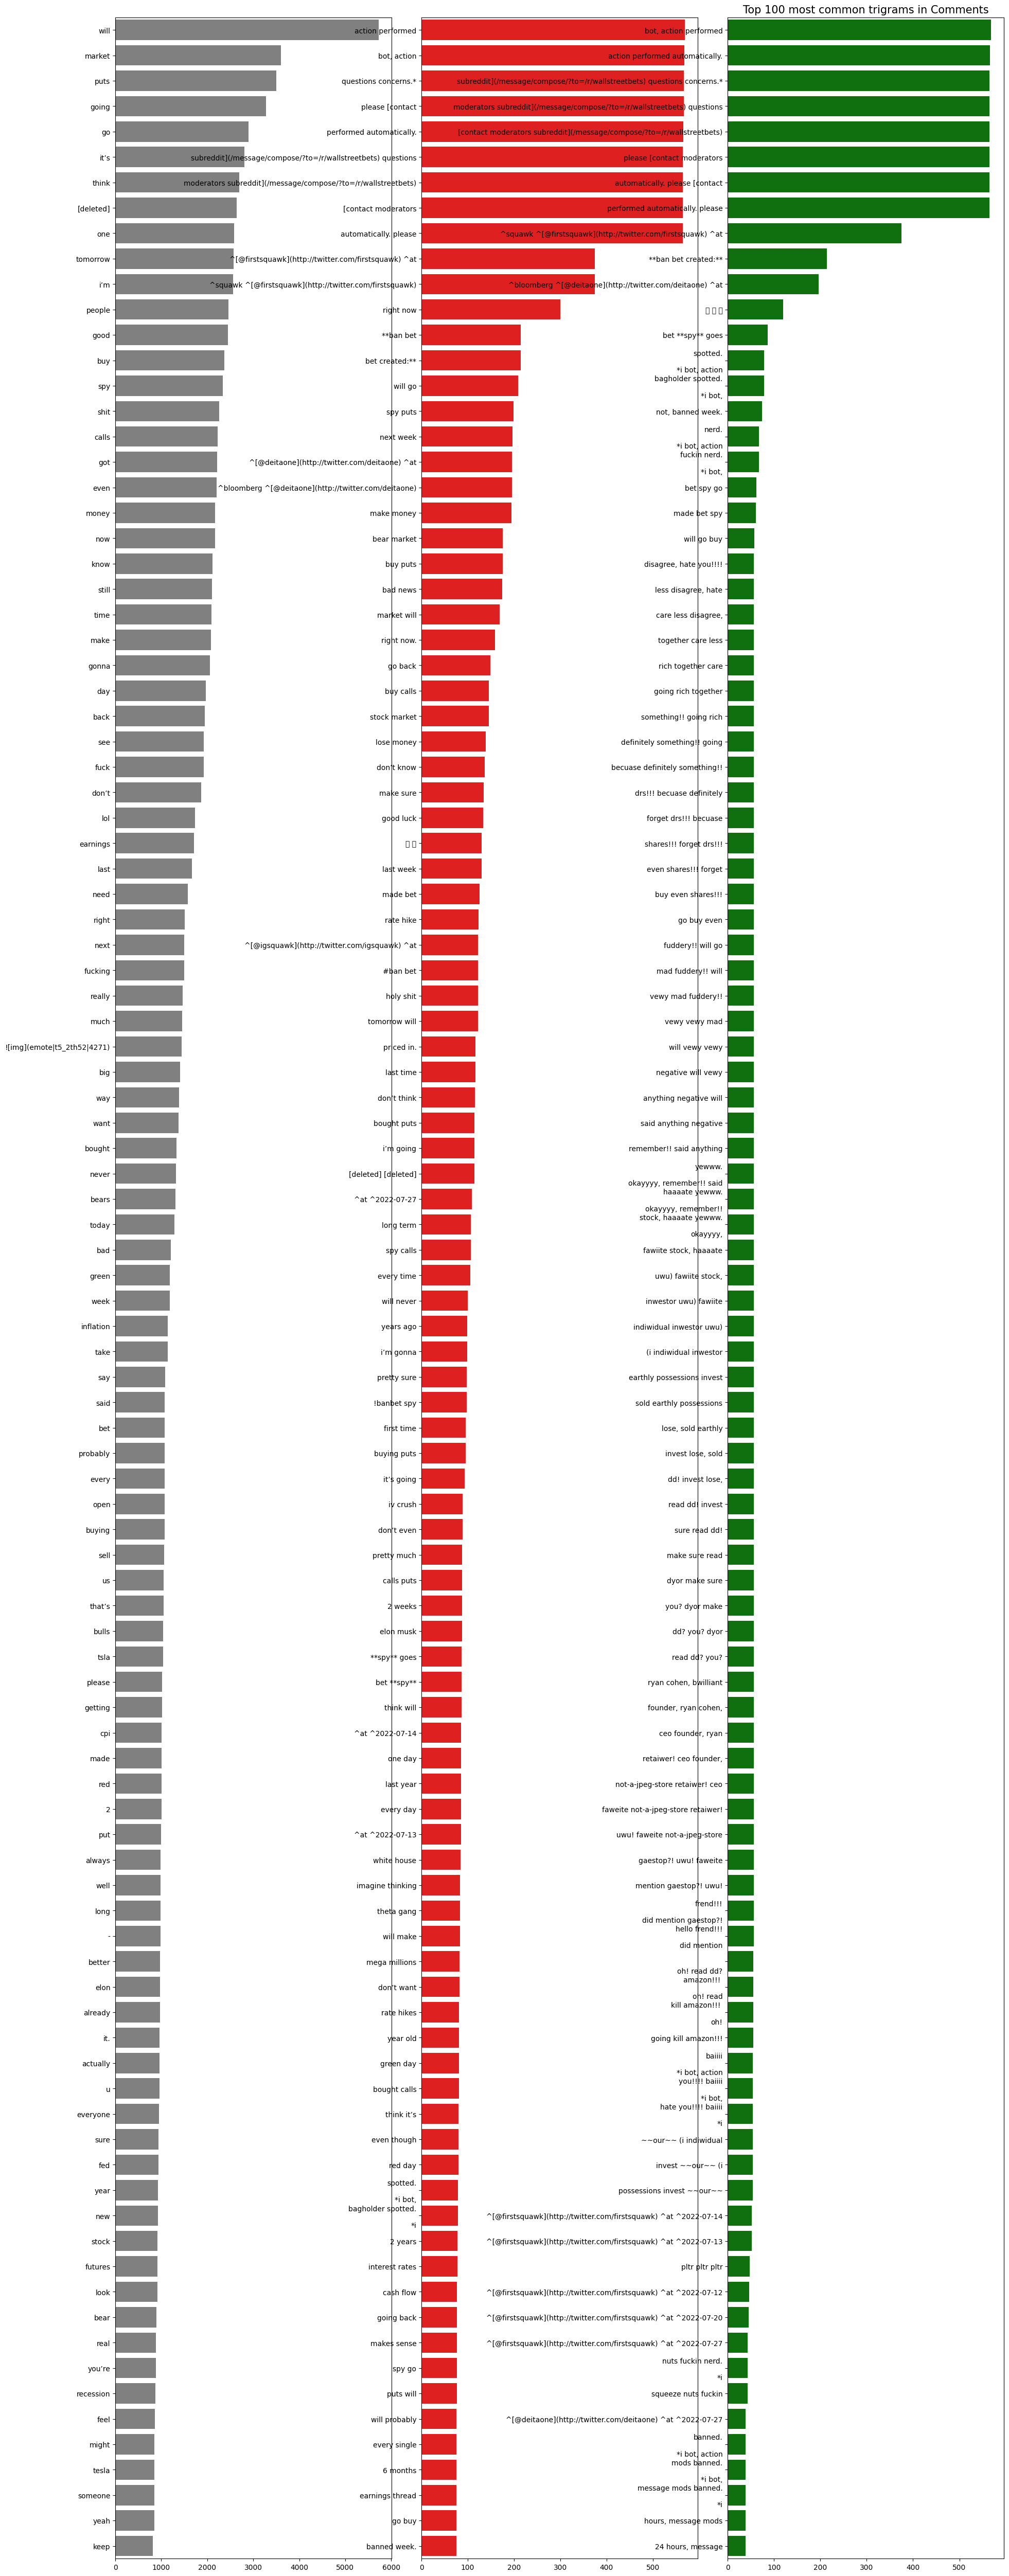

In [18]:
# 3. Ngrams
# visualisation for Unigrams
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams[0].values[:N], x=df_unigrams[1].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Comments', fontsize=15)

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Comments', fontsize=15)

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Comments', fontsize=15)

plt.show()

In [19]:
# 1.4. sentiment distribution
# apply if database built can identify each comments saperately
'''
sia = SentimentIntensityAnalyzer()
#apply sentiment analysis
consol_df['sentiment'] = consol_df['comments'].apply(lambda x: sia.polarity_scores(x))

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in consol_df['sentiment']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(consol_df)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
'''

"\nsia = SentimentIntensityAnalyzer()\n#apply sentiment analysis\nconsol_df['sentiment'] = consol_df['comments'].apply(lambda x: sia.polarity_scores(x))\n\n# Initialize counters for different sentiment labels\npositive_count = 0\nnegative_count = 0\nneutral_count = 0\n\n# Count the occurrences of each sentiment label\nfor scores in consol_df['sentiment']:\n    compound_score = scores['compound']\n    if compound_score > 0.05:\n        positive_count += 1\n    elif compound_score < -0.05:\n        negative_count += 1\n    else:\n        neutral_count += 1\n\n# Calculate the relative frequencies of each sentiment label\ntotal_count = len(consol_df)\npositive_percent = positive_count / total_count\nnegative_percent = negative_count / total_count\nneutral_percent = neutral_count / total_count\n\n# Visualize the sentiment distribution using a pie chart\nlabels = ['Positive', 'Negative', 'Neutral']\nsizes = [positive_percent, negative_percent, neutral_percent]\ncolors = ['green', 'red', 'gra

In [20]:
# 1.5. topic distribution (topic modeling algorithms (e.g., LDA, NMF))
# unsupervised classificaton
# apply if database built can identify each comments saperately
'''
'''

'\n'

## 2. Data processing

  1. Clean the comments with neutral words
  - option 1: NLTK - stop words
  - option 2: SK_Learn - ENGLISH_STOP_WORDS
  2. Stemming or lemmatization
  3. clean the text with embedding (Glove/ Fasttext)
  4. Clean text per N-gram
  5. Inspection after processing



## 2.1 clean the comments with neutral words


In [21]:
# option 1: NLTK - stop words

import nltk
from nltk.corpus import stopwords

In [22]:
# option 1: NLTK - stop words
# to clean the data set

# Get the stopwords
stopwords = stopwords.words('english')

# Apply preprocessing to each comment

#decode it with utf-8

train_df['new_text'] = train_df['comments'].apply(lambda text: text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore'))

'''
# Tokenization
# Split the raw text into individual tokens
consol_df['new_text'] = consol_df['new_text'].apply(word_tokenize)
'''

#convert to all small case

train_df['new_text'] = train_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords]))

# Print the updated DataFrame
print(train_df)

# do same to text_df
test_df['new_text'] = test_df['comments'].apply(lambda text: text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore'))
test_df['new_text'] = test_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords]))



         date                                           comments  word_count  \
0  2022-07-13  This week's [Earnings Thread](https://www.redd...      138815   
1  2022-07-14  This week's [Earnings Thread](https://www.redd...      128463   
2  2022-07-15  Cashed out up 56k today. Now cuddled up watchi...      129171   
3  2022-07-19  This week's [Earnings Thread](https://www.redd...      117785   
4  2022-07-20  If 2008 was the Great Recession\n\nThen 2022 i...      139839   
5  2022-07-21  airbnb is more expensive than hotels\n\nuber i...      135075   
6  2022-07-25  I got a free share of SIRI when I signed up fo...       98712   
7  2022-07-26  Whoever yolo’d 13k contracts of walmart 130 pu...      133111   
8  2022-07-27  I have google puts and msft calls 🤡 I had a se...      140046   
9  2022-07-28  META ER will be hilarious\n\n"yeah we're tryin...      137115   

   unique_word_count  stop_word_count  url_count  mean_word_length  \
0              21625            58161        228 

In [23]:
# option 2: SK learn - ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(ENGLISH_STOP_WORDS)

frozenset({'upon', 'due', 'each', 'and', 'anything', 'behind', 'himself', 'you', 'or', 'me', 'rather', 'last', 'others', 'but', 'etc', 'full', 'sometime', 'after', 'toward', 'along', 'has', 'move', 'otherwise', 'back', 'beside', 'i', 'many', 'go', 'either', 'we', 'ltd', 'what', 'its', 'former', 'someone', 'fifteen', 'about', 'between', 'them', 'itself', 'may', 'below', 'there', 'six', 'how', 'a', 'amongst', 'interest', 'next', 'here', 'however', 'mine', 'few', 'nobody', 'somehow', 'whole', 'take', 'my', 'to', 'latter', 'other', 'indeed', 'two', 'why', 'eg', 'couldnt', 'across', 'than', 'hereafter', 'sixty', 'anywhere', 'as', 'three', 'nine', 'becoming', 'thus', 'whence', 'often', 'most', 'become', 'without', 'herein', 'forty', 'became', 'anyway', 'whatever', 'alone', 'thin', 'although', 'namely', 'then', 'would', 'again', 'sincere', 'even', 'seemed', 'wherever', 'these', 'elsewhere', 'whereupon', 'almost', 'thereby', 'that', 'now', 'hereby', 'for', 'ten', 'from', 'amoungst', 'third', '

In [24]:
# option 2: SK learn - ENGLISH_STOP_WORDS
# to clean the date set

# Get the stopwords
stopwords_sk = ENGLISH_STOP_WORDS

#convert to lower cases
# Apply preprocessing to each comment
train_df['new_text'] = train_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords_sk]))

# Print the updated DataFrame
print(train_df)

#do same to test set
test_df['new_text'] = test_df['new_text'].apply(lambda text: ' '.join([word.lower() for word in text.split() if word.lower() not in stopwords_sk]))


         date                                           comments  word_count  \
0  2022-07-13  This week's [Earnings Thread](https://www.redd...      138815   
1  2022-07-14  This week's [Earnings Thread](https://www.redd...      128463   
2  2022-07-15  Cashed out up 56k today. Now cuddled up watchi...      129171   
3  2022-07-19  This week's [Earnings Thread](https://www.redd...      117785   
4  2022-07-20  If 2008 was the Great Recession\n\nThen 2022 i...      139839   
5  2022-07-21  airbnb is more expensive than hotels\n\nuber i...      135075   
6  2022-07-25  I got a free share of SIRI when I signed up fo...       98712   
7  2022-07-26  Whoever yolo’d 13k contracts of walmart 130 pu...      133111   
8  2022-07-27  I have google puts and msft calls 🤡 I had a se...      140046   
9  2022-07-28  META ER will be hilarious\n\n"yeah we're tryin...      137115   

   unique_word_count  stop_word_count  url_count  mean_word_length  \
0              21625            58161        228 

## 2.2. clean the text with embedding (Glove/ Fasttext) - for sentiment analysis

In [25]:
# 1. clean the text with embedding
# clean the text
# then check coverage on the cleaned text again

%%time

# Convert 'consol_df['tokens']' column to string
train_df['new_text'] = train_df['new_text'].astype(str)
test_df['new_text'] = test_df['new_text'].astype(str)


def clean(comment):


    # #1 - eomte

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    comment = re.sub(emote_pattern,"", comment)


    # Urls
    comment = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", comment)

    # Words with punctuations and special characters
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,' + "'`’"
    for p in punctuations:
        comment = comment.replace(p, ' ')

    return comment

train_df['embeddings_tokens'] = train_df['new_text'].apply(lambda s : clean(s))
test_df['embeddings_tokens'] = test_df['new_text'].apply(lambda s : clean(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(train_df['embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(train_df['embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(fasttext_vocab_coverage, fasttext_text_coverage))


GloVe Embeddings cover 78.38% of vocabulary and 96.83% of text in Training Set
FastText Embeddings cover 77.86% of vocabulary and 96.99% of text in Training Set
CPU times: user 1.22 s, sys: 3.47 ms, total: 1.23 s
Wall time: 1.27 s


In [26]:
# count the removed pattern
'''
def df_pattern(comment, df):

    emote_pattern = r"!\[img]\(emote\|[^)]*\)"  # Regex pattern to match the desired pattern
    matches = re.findall(emote_pattern, comment)
    pattern_counts = {}

      # Count the patterns
    for match in matches:
        if match in pattern_counts:
            pattern_counts[match] += 1
        else:
            pattern_counts[match] = 1

    df_input = pd.DataFrame({'Count': list(pattern_counts.values())}, index=list(pattern_counts.keys()))
    df_transposed = df.T
    df = df.append(df_transposed, ignore_index=False)

    return df

#initialise
df_pattern = pd.DataFrame()

# Create a dataframe from the pattern counts
df_pattern = (consol_df['new_text'],df_pattern).apply(lambda s : df_pattern(s))
df_pattern['date'] = consol_df['date']

'''

'\ndef df_pattern(comment, df):\n\n    emote_pattern = r"!\\[img]\\(emote\\|[^)]*\\)"  # Regex pattern to match the desired pattern\n    matches = re.findall(emote_pattern, comment)\n    pattern_counts = {}\n\n      # Count the patterns\n    for match in matches:\n        if match in pattern_counts:\n            pattern_counts[match] += 1\n        else:\n            pattern_counts[match] = 1\n\n    df_input = pd.DataFrame({\'Count\': list(pattern_counts.values())}, index=list(pattern_counts.keys()))\n    df_transposed = df.T\n    df = df.append(df_transposed, ignore_index=False)\n\n    return df\n\n#initialise\ndf_pattern = pd.DataFrame()\n\n# Create a dataframe from the pattern counts\ndf_pattern = (consol_df[\'new_text\'],df_pattern).apply(lambda s : df_pattern(s))\ndf_pattern[\'date\'] = consol_df[\'date\']\n\n'

In [27]:
# 1. clean the text with embedding
# save a copy of clean text
'''
consol_df.to_csv('consol_df.csv')
'''

"\nconsol_df.to_csv('consol_df.csv')\n"

In [28]:
# consol_df = pd.read_csv('consol_df.csv')

In [29]:
# 1. clean the text with embedding
# After cleaning, glove_embeddings and fasttext_embeddings are deleted and garbage collected because they consume too much memory (10+ gigabytes).
'''
del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()
'''

'\ndel glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,\ngc.collect()\n'

In [30]:
# 2nd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_second = defaultdict(int)

for cmt in train_df['embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_second[word] += 1

df_unigrams_cleaned_second = pd.DataFrame(sorted(consol_unigrams_cleaned_second.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_second = defaultdict(int)

for cmt in train_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_second[word] += 1

df_bigrams_cleaned_second = pd.DataFrame(sorted(consol_bigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_second = defaultdict(int)

for cmt in train_df['embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_second[word] += 1

df_trigrams_cleaned_second = pd.DataFrame(sorted(consol_trigrams_cleaned_second.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_second

grams  count
0                                                 2022 07   1035
1                                                edt 0400    758
2                                         message compose    631
3                                        action performed    569
4                                              bot action    569
...                                                   ...    ...
476928                                         dataa know      1
476929                                          old dataa      1
476930  the_wsb_trash_bin_discussion_thread_for_the_we...      1
476931  v96vnt the_wsb_trash_bin_discussion_thread_for...      1
476932                                    comments v96vnt      1

[476933 rows x 2 columns]

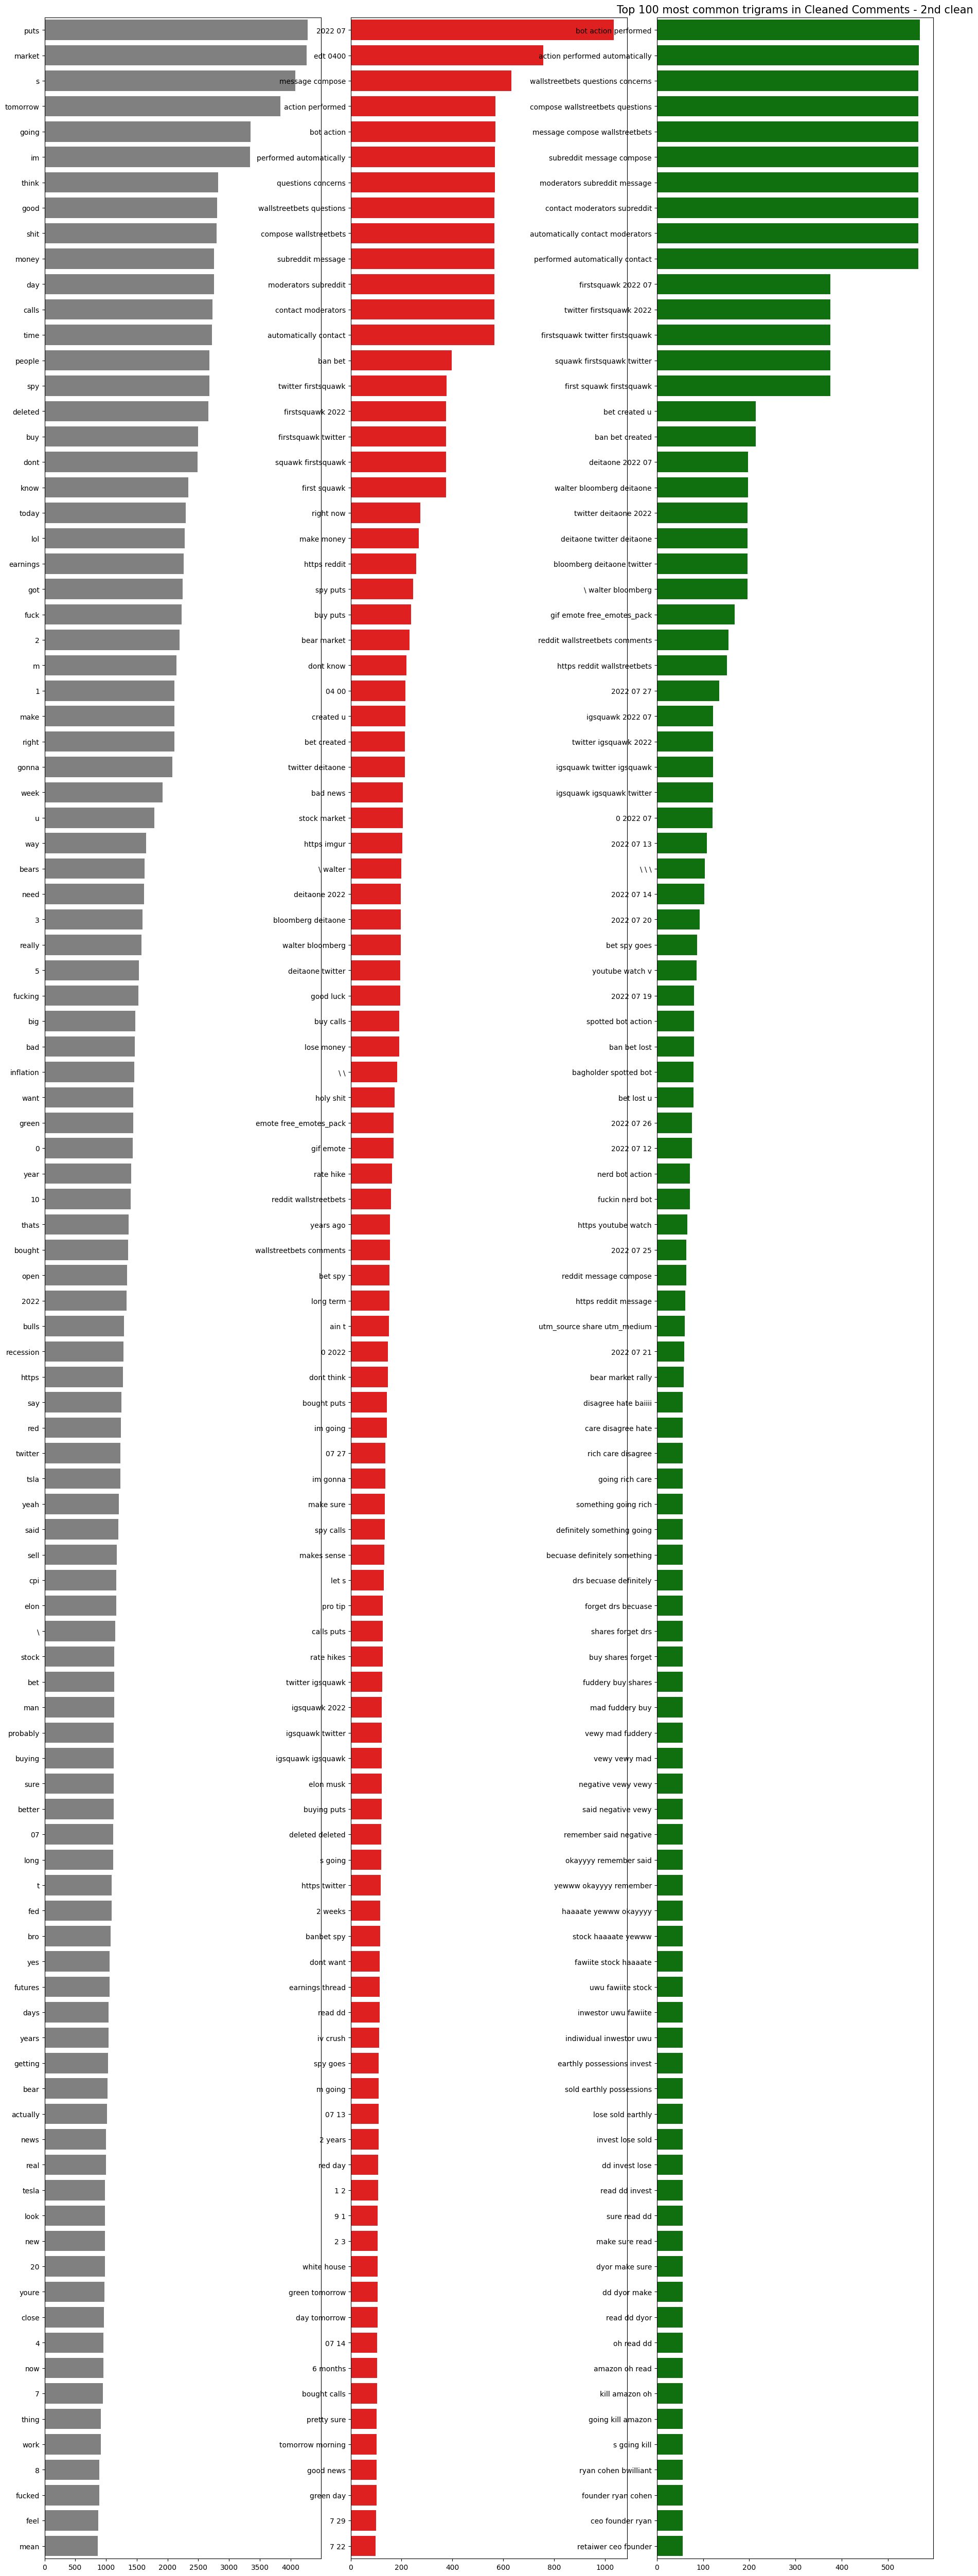

In [31]:
# 2nd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_second['grams'].values[:N], x=df_unigrams_cleaned_second['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_second['grams'].values[:N], x=df_bigrams_cleaned_second['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 2nd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_second['grams'].values[:N], x=df_trigrams_cleaned_second['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 2nd clean', fontsize=15)

plt.show()

## 2.3. Clean per N-gram

In [32]:
# 3rd round cleaned
# criteria: by reading the N-gram ranking


%%time

def clean_second(comment):

    comment = re.sub(r"\bai ai ai\b", "ai", comment)
    comment = re.sub(r"\bai ai\b", "ai", comment)
    comment = re.sub(r'compose', '', comment)
    comment = re.sub(r'moderators', '', comment)
    comment = re.sub(r'\bm\b', '', comment)
    comment = re.sub(r'\bs\b', '', comment)
    comment = re.sub(r'\bu\b', '', comment)
    comment = re.sub(r'\b1\b', '', comment)
    comment = re.sub(r'\b2\b', '', comment)
    comment = re.sub(r'\bim\b', '', comment)
    comment = re.sub(r"   ", " ", comment)
    comment = re.sub(r"  ", " ", comment)


    return comment

train_df['ngrams_embeddings_tokens'] = train_df['embeddings_tokens'].apply(lambda s : clean_second(s))
test_df['ngrams_embeddings_tokens'] = test_df['embeddings_tokens'].apply(lambda s : clean_second(s))

glove_oov, glove_vocab_coverage, glove_text_coverage = check_embeddings_coverage(train_df['ngrams_embeddings_tokens'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(glove_vocab_coverage, glove_text_coverage))

fasttext_oov, fasttext_vocab_coverage, fasttext_text_coverage = check_embeddings_coverage(train_df['ngrams_embeddings_tokens'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set - 3rd clean'.format(fasttext_vocab_coverage, fasttext_text_coverage))

GloVe Embeddings cover 78.39% of vocabulary and 96.76% of text in Training Set - 3rd clean
FastText Embeddings cover 77.87% of vocabulary and 96.92% of text in Training Set - 3rd clean
CPU times: user 3.24 s, sys: 11.5 ms, total: 3.25 s
Wall time: 3.3 s


In [33]:
# 3rd round cleaned
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_third = defaultdict(int)

for cmt in train_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_third[word] += 1

df_unigrams_cleaned_third = pd.DataFrame(sorted(consol_unigrams_cleaned_third.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_third = defaultdict(int)

for cmt in train_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_third[word] += 1

df_bigrams_cleaned_third = pd.DataFrame(sorted(consol_bigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_third = defaultdict(int)

for cmt in train_df['ngrams_embeddings_tokens']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_third[word] += 1

df_trigrams_cleaned_third = pd.DataFrame(sorted(consol_trigrams_cleaned_third.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_third

grams  count
0                                                 2022 07   1035
1                                                edt 0400    758
2                                        action performed    569
3                                              bot action    569
4                                 performed automatically    567
...                                                   ...    ...
474095                                         dataa know      1
474096                                          old dataa      1
474097  the_wsb_trash_bin_discussion_thread_for_the_we...      1
474098  v96vnt the_wsb_trash_bin_discussion_thread_for...      1
474099                                    comments v96vnt      1

[474100 rows x 2 columns]

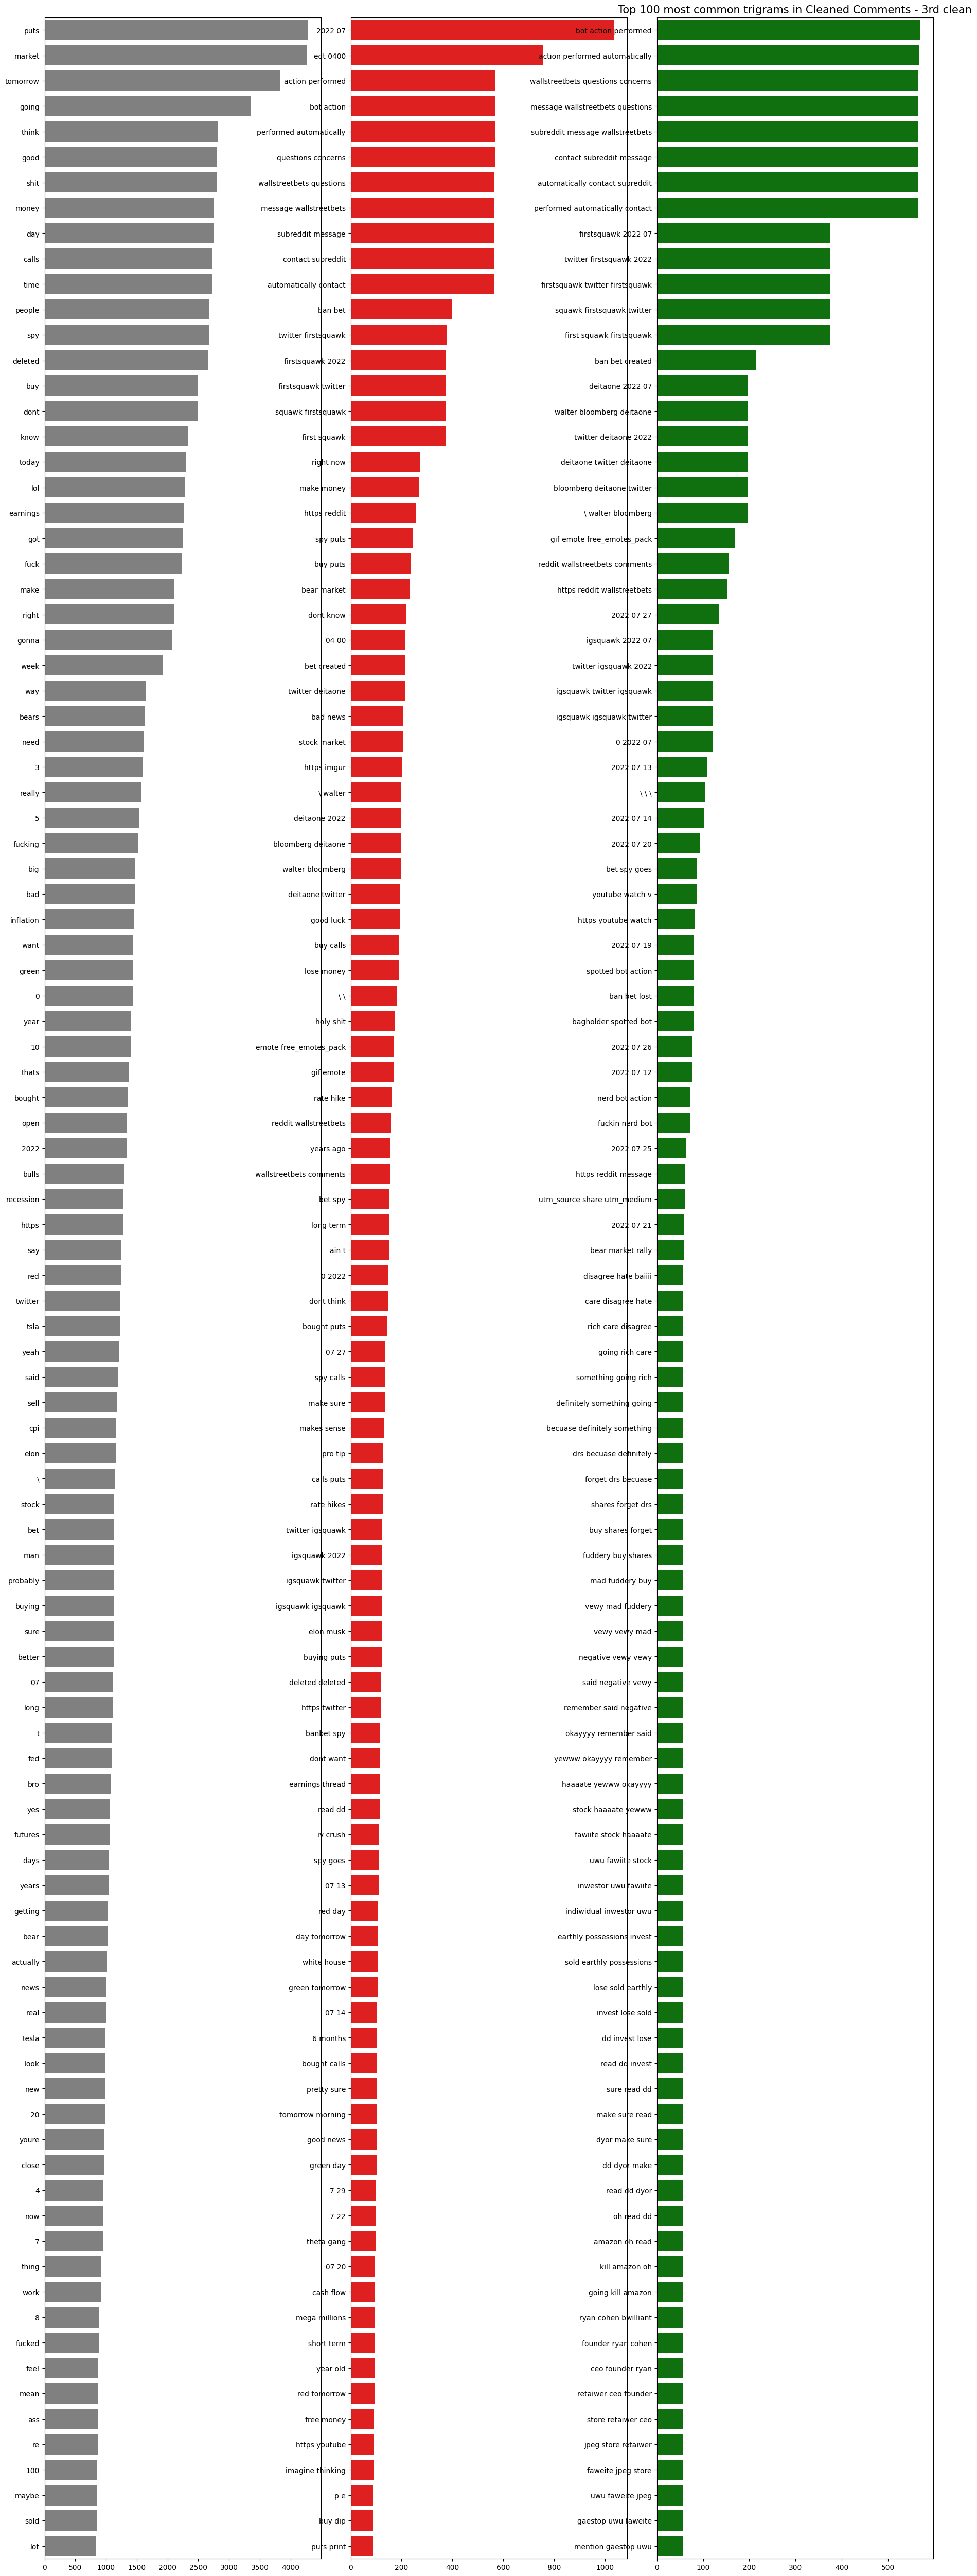

In [34]:
# 3rd round cleaned
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_third['grams'].values[:N], x=df_unigrams_cleaned_third['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_third['grams'].values[:N], x=df_bigrams_cleaned_third['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_third['grams'].values[:N], x=df_trigrams_cleaned_third['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

## 2.4. Stemming or lemmatization

In [35]:

# Stemming
train_df['tokens'] = train_df['ngrams_embeddings_tokens'].apply(word_tokenize)

# Step 2: Choose a Stemming or Lemmatization Algorithm
# Select a stemming or lemmatization algorithm
stemmer = PorterStemmer()

# Step 3: Apply Stemming or Lemmatization
# Apply the chosen algorithm to each token
train_df['stemmed_tokens'] = train_df['tokens'].apply(lambda x: [stemmer.stem(token) for token in x])
# Step 4: Reconstruct the Text
# Reconstruct the text by joining the stemmed or lemmatized tokens
train_df['stemmed_text'] = train_df['stemmed_tokens'].apply(lambda x: ' '.join(x))

# do the same to test set
test_df['tokens'] = test_df['ngrams_embeddings_tokens'].apply(word_tokenize)
test_df['stemmed_tokens'] = test_df['tokens'].apply(lambda x: [stemmer.stem(token) for token in x])
test_df['stemmed_text'] = test_df['stemmed_tokens'].apply(lambda x: ' '.join(x))

In [36]:
# Lemmatization


# Select a stemming or lemmatization algorithm
lemmatizer = WordNetLemmatizer()
# Apply the chosen algorithm to each token
train_df['lemmatized_tokens'] = train_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
# Reconstruct the text by joining the stemmed or lemmatized tokens
train_df['lemmatized_text'] = train_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# do the same to test set
test_df['lemmatized_tokens'] = test_df['tokens'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])
test_df['lemmatized_text'] = test_df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

##2.5. Inspection after processing

In [37]:
#  Inspection after processing
# generate ngrams in the cleaned text
# Unigrams
consol_unigrams_cleaned_final = defaultdict(int)

for cmt in train_df['stemmed_text']:
    for word in generate_ngrams(cmt):
        consol_unigrams_cleaned_final[word] += 1

df_unigrams_cleaned_final = pd.DataFrame(sorted(consol_unigrams_cleaned_final.items(), key=lambda x: x[1])[::-1],columns=['grams', 'count'])

# Bigrams
consol_bigrams_cleaned_final = defaultdict(int)

for cmt in train_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=2):
        consol_bigrams_cleaned_final[word] += 1

df_bigrams_cleaned_final = pd.DataFrame(sorted(consol_bigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

# Trigrams
consol_trigrams_cleaned_final = defaultdict(int)

for cmt in train_df['stemmed_text']:
    for word in generate_ngrams(cmt, n_gram=3):
        consol_trigrams_cleaned_final[word] += 1

df_trigrams_cleaned_final = pd.DataFrame(sorted(consol_trigrams_cleaned_final.items(), key=lambda x: x[1])[::-1], columns=['grams', 'count'])

df_bigrams_cleaned_final

grams  count
0                                                  gon na   2077
1                                                 2022 07   1035
2                                                edt 0400    758
3                                          action perform    569
4                                              bot action    569
...                                                   ...    ...
430369                                         dataa know      1
430370                                          old dataa      1
430371  the_wsb_trash_bin_discussion_thread_for_the_we...      1
430372  v96vnt the_wsb_trash_bin_discussion_thread_for...      1
430373                                     comment v96vnt      1

[430374 rows x 2 columns]

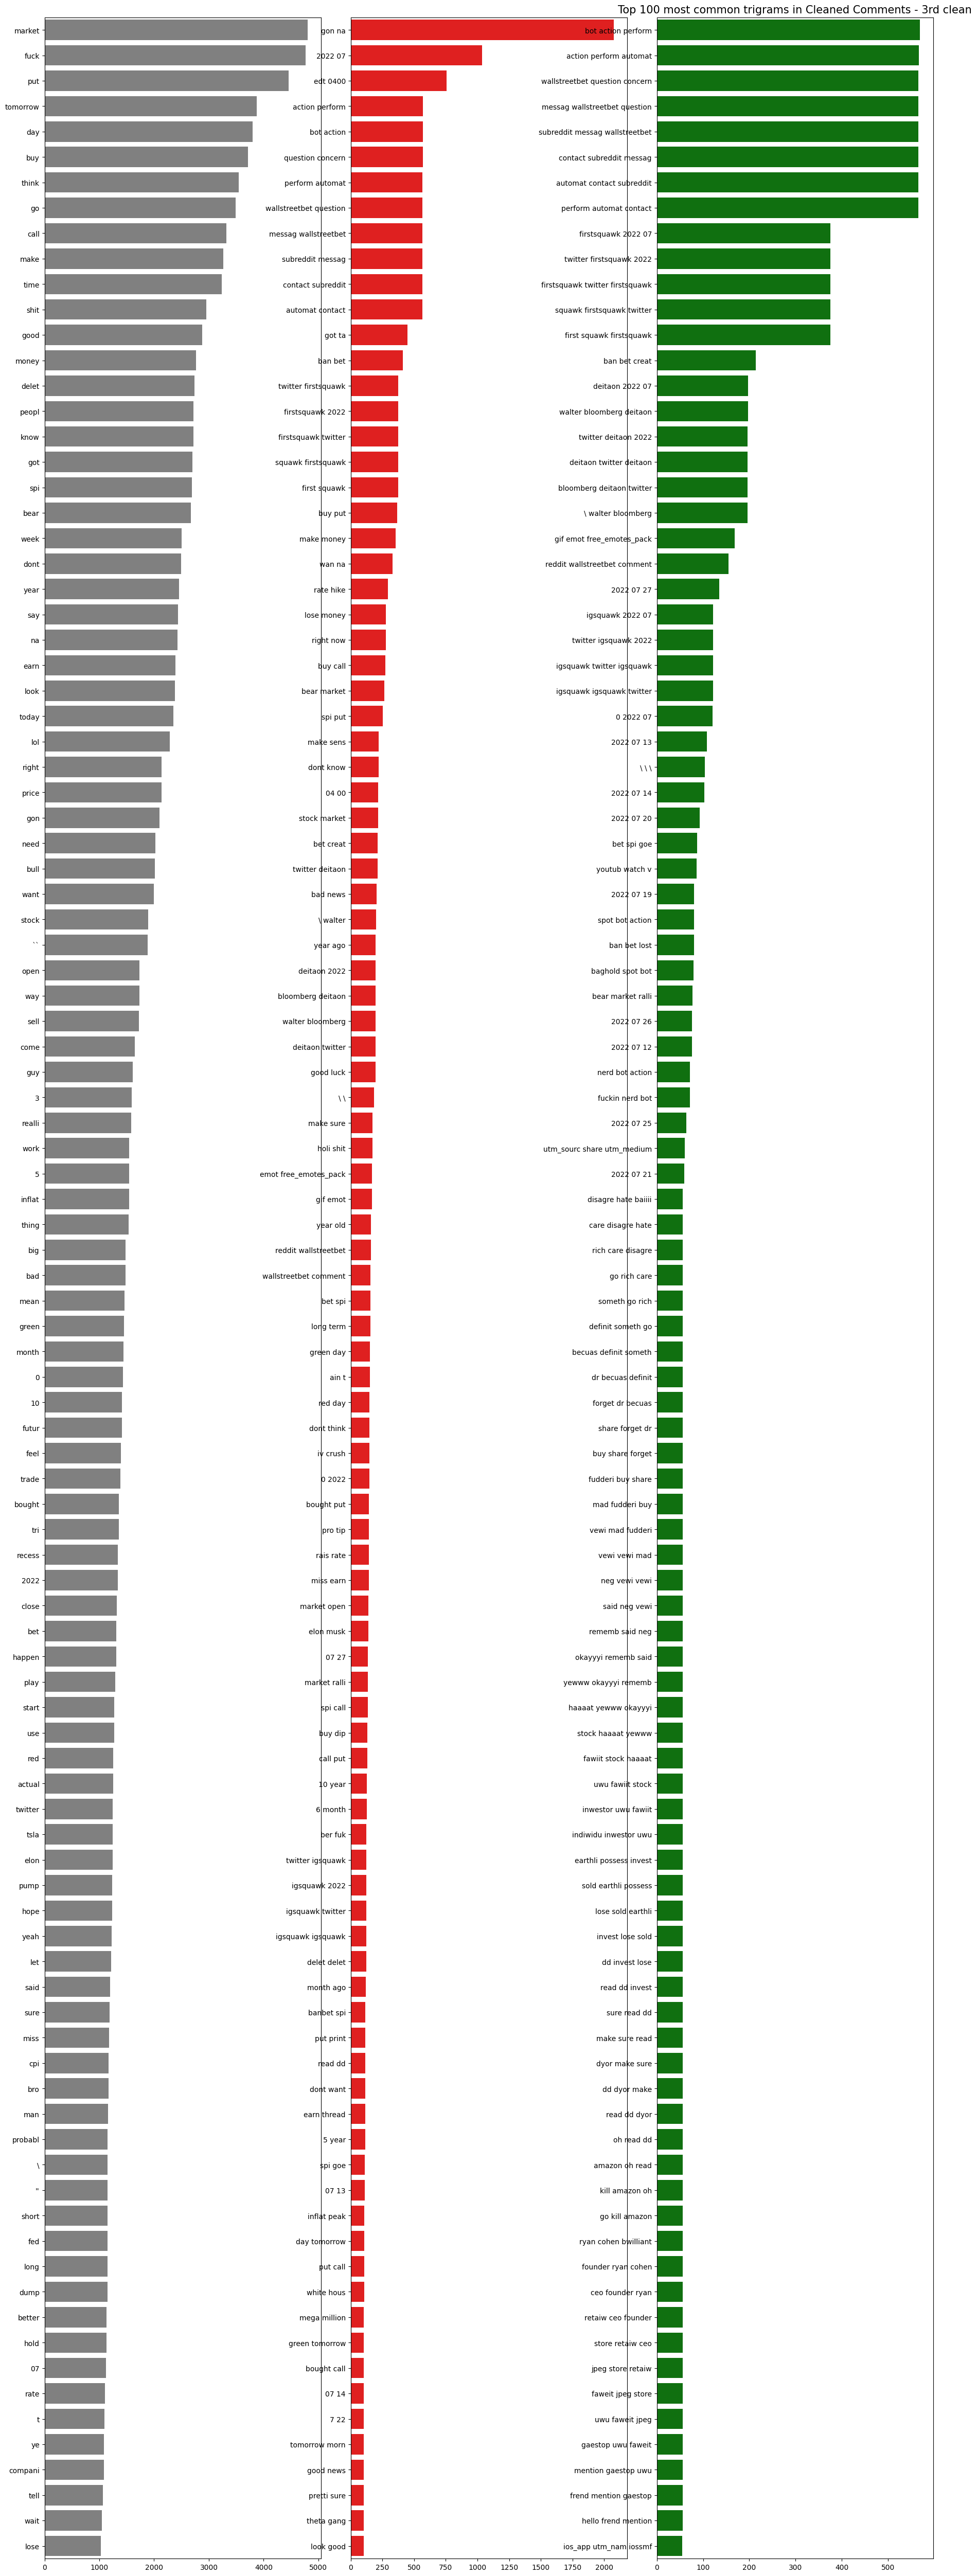

In [38]:
# Inspection after processing
# visualisation for N-grams cleaned

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(18, 50), dpi=100)
plt.tight_layout()

# 繪製條形圖
sns.barplot(y=df_unigrams_cleaned_final['grams'].values[:N], x=df_unigrams_cleaned_final['count'].values[:N], ax=axes[0], color='gray')
plt.title(f'Top {N} most common unigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_bigrams_cleaned_final['grams'].values[:N], x=df_bigrams_cleaned_final['count'].values[:N], ax=axes[1], color='red')
plt.title(f'Top {N} most common bigrams in Cleaned Comments - 3rd clean', fontsize=15)

sns.barplot(y=df_trigrams_cleaned_final['grams'].values[:N], x=df_trigrams_cleaned_final['count'].values[:N], ax=axes[2], color='green')
plt.title(f'Top {N} most common trigrams in Cleaned Comments - 3rd clean', fontsize=15)

plt.show()

# 3. Features engineering

  1. Sentiment analysis on top n-grams
      - option 1 - NLTK
      - option 2 - Textblob
      - option 3 - specific for financial terms
  2. Time-series



In [39]:
# Generate the list of N-grams
df_unigrams_cleaned_third_tomerge = df_unigrams_cleaned_third[:20]

'''
df_bigrams_cleaned_third_tomerge = df_bigrams_cleaned_third[:20]

df_trigrams_cleaned_third_tomerge = df_trigrams_cleaned_third[:20]
'''

df_unigrams_cleaned_third_tomerge


grams  count
0       puts   4281
1     market   4261
2   tomorrow   3833
3      going   3350
4      think   2819
5       good   2808
6       shit   2801
7      money   2757
8        day   2752
9      calls   2728
10      time   2722
11    people   2681
12       spy   2680
13   deleted   2665
14       buy   2497
15      dont   2490
16      know   2337
17     today   2292
18       lol   2283
19  earnings   2263

In [40]:
# Generate the list of N-grams
# create a series contiaing first 100 unigram, bigram , trigram

list_top100gram = df_unigrams_cleaned_third_tomerge['grams']
          # pd.concat([df_unigrams_cleaned_third_tomerge['grams'] , df_bigrams_cleaned_third_tomerge['grams'] , df_trigrams_cleaned_third_tomerge['grams']], axis=0)
list_top100gram

0         puts
1       market
2     tomorrow
3        going
4        think
5         good
6         shit
7        money
8          day
9        calls
10        time
11      people
12         spy
13     deleted
14         buy
15        dont
16        know
17       today
18         lol
19    earnings
Name: grams, dtype: object

In [43]:
# Generate the list of N-grams
# create a df containings n columns each with 1 key word, each row of record shows the count of frequency of each keyword in the raw text

df_top100gram = pd.DataFrame(columns=list_top100gram, index=train_df.index)
for i, row in train_df.iterrows():
    for gram in list_top100gram:
        count = row['ngrams_embeddings_tokens'].count(gram)
        df_top100gram.at[i, gram] = count

df_top100gram['date'] = train_df['date']
df_top100gram

grams puts market tomorrow going think good shit money   day calls  ...  \
0      464    414      527   357   400  283  369   290   701   259  ...   
1      375    455      364   293   351  302  336   318  1005   235  ...   
2      478    573      569   356   330  306  351   294   971   291  ...   
3      372    360      226   264   306  279  355   223   746   229  ...   
4      593    600      470   393   388  311  364   333   989   378  ...   
5      392    498      404   351   355  315  435   305   735   321  ...   
6      235    280      107   266   292  231  293   200   499   164  ...   
7      414    514      293   336   395  307  442   263   719   240  ...   
8      488    668      535   402   394  333  443   257   887   376  ...   
9      491    671      431   353   372  324  369   313   996   252  ...   

grams people  spy deleted  buy dont know today  lol earnings        date  
0        238  312     240  416  264  339   204  178       88  2022-07-13  
1        254  290     323  411  237  285   312  207      100  2022-07-14  
2        259  333     229  424  280  291   262  221      160  2022-07-15  
3        259  238     258  302  246  240   252  247      185  2022-07-19  
4        268  390     263  446  280  304   314  274      304  2022-07-20  
5        246  254     303  366  253  308   190  338      287  2022-07-21  
6        235  118     211  256  168  247    65  144      101  2022-07-25  
7        415  268     278  449  234  275   186  226      274  2022-07-26  
8        299  249     318  402  279  320   235  285      517  2022-07-27  
9        263  272     243  418  258  279   341  267      257  2022-07-28  

[10 rows x 21 columns]

In [44]:
# Generate the list of N-grams
#back up the training data set

df_top100gram.to_csv('df_top20gram_Jun_testing.csv')

## 3.1. Sentiment analysis

In [45]:
# adoption of sentiment analysis models
# option 1 - NLTK

sia = SentimentIntensityAnalyzer()

#apply sentiment analysis
df_top100gram_nltk = pd.DataFrame()
df_top100gram_nltk['grams'] = list_top100gram
df_top100gram_nltk['sentiment_score'] = list_top100gram.apply(lambda x: sia.polarity_scores(x))

df_top100gram_nltk

grams                                    sentiment_score
0       puts  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1     market  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2   tomorrow  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
3      going  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4      think  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5       good  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
6       shit  {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...
7      money  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
8        day  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9      calls  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
10      time  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
11    people  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
12       spy  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
13   deleted  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
14       buy  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
15      dont  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
16      know  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
17     today  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
18       lol  {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
19  earnings  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...

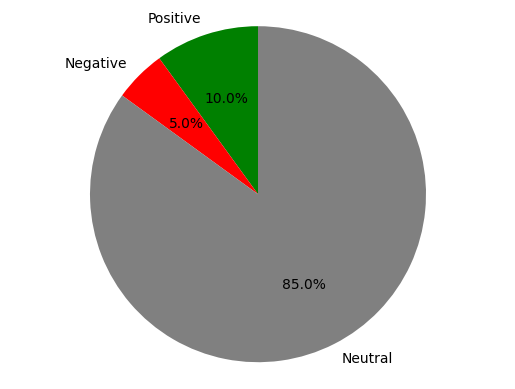

In [46]:
# option 1 - NLTK
#Statistics

# Initialize counters for different sentiment labels
positive_count = 0
negative_count = 0
neutral_count = 0

# Count the occurrences of each sentiment label
for scores in df_top100gram_nltk['sentiment_score']:
    compound_score = scores['compound']
    if compound_score > 0.05:
        positive_count += 1
    elif compound_score < -0.05:
        negative_count += 1
    else:
        neutral_count += 1

# Calculate the relative frequencies of each sentiment label
total_count = len(df_top100gram_nltk)
positive_percent = positive_count / total_count
negative_percent = negative_count / total_count
neutral_percent = neutral_count / total_count

# Visualize the sentiment distribution using a pie chart
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_percent, negative_percent, neutral_percent]
colors = ['green', 'red', 'gray']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

In [47]:
# option 2 - TextBlob

from textblob import TextBlob

In [48]:
# option 2 - TextBlob

# Perform sentiment analysis on each financial data point
sentiments_textblob = []

for word in list_top100gram:
    blob = TextBlob(word)
    polarity = blob.sentiment.polarity

    if polarity > 0:
        sentiment = "positive"
    elif polarity < 0:
        sentiment = "negative"
    else:
        sentiment = "neutral"

    sentiments_textblob.append({
        "Word": word,
        "Sentiment": sentiment
    })

sentiments_textblob_df = pd.DataFrame(sentiments_textblob)
print(sentiments_textblob_df)

# Convert sentiments list to a pandas DataFrame
df_top100gram_textblob = pd.DataFrame(sentiments_textblob)

df_top100gram_textblob

        Word Sentiment
0       puts   neutral
1     market   neutral
2   tomorrow   neutral
3      going   neutral
4      think   neutral
5       good  positive
6       shit  negative
7      money   neutral
8        day   neutral
9      calls   neutral
10      time   neutral
11    people   neutral
12       spy   neutral
13   deleted   neutral
14       buy   neutral
15      dont   neutral
16      know   neutral
17     today   neutral
18       lol  positive
19  earnings   neutral


Word Sentiment
0       puts   neutral
1     market   neutral
2   tomorrow   neutral
3      going   neutral
4      think   neutral
5       good  positive
6       shit  negative
7      money   neutral
8        day   neutral
9      calls   neutral
10      time   neutral
11    people   neutral
12       spy   neutral
13   deleted   neutral
14       buy   neutral
15      dont   neutral
16      know   neutral
17     today   neutral
18       lol  positive
19  earnings   neutral

In [ ]:
df_top100gram_textblob.to_csv('gram_bert.csv')

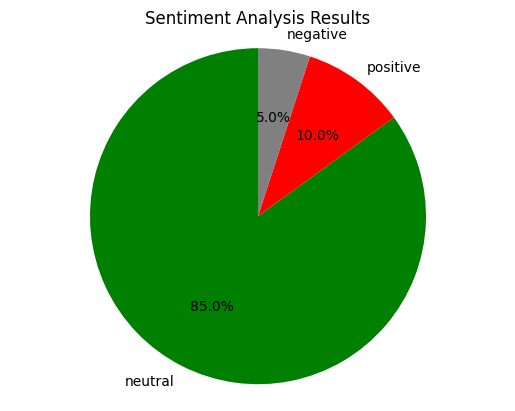

In [49]:
# option 2 - TextBlob
#Statistics

# Initialize counters for different sentiment labels
sentiment_counts = df_top100gram_textblob['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
sizes = sentiment_counts.values.tolist()

colors = ['green', 'red', 'gray']  # Customize colors for positive, negative, and neutral sentiments

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart

plt.title('Sentiment Analysis Results')
plt.show()

In [50]:
#option 3 - specific for financial terms
# Embeddings

# Initialize an empty list to store word vectors
word_vectors = []

# Iterate over each word
for word in list_top100gram:
    try:
        # Get the word vector from the GloVe embeddings dictionary
        vector = glove_embeddings[word]
        word_vectors.append(vector)
    except KeyError:
        print(f"Word '{word}' not found in the glove_embeddings dictionary.")
        word_vectors.append(np.zeros(len(glove_embeddings[next(iter(glove_embeddings))])))

# Create a DataFrame with the word vectors
columns = [f"dim_{i}" for i in range(len(word_vectors[0]))]
glove_embeddings_df = pd.DataFrame(word_vectors, index=list_top100gram, columns=columns)
glove_embeddings_df.index.name = "Word"


glove_embeddings_df


dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
Word                                                                   
puts     -0.201530  0.091056  0.003293  0.136360  0.097221 -0.171100   
market   -0.196040  0.536560  0.096780  0.091406  0.552390 -0.356280   
tomorrow  0.229250  0.398980 -0.148250  0.199730  0.000208 -0.568790   
going    -0.058157  0.315030 -0.398830  0.079551  0.217990 -0.129720   
think    -0.217880  0.441280 -0.432040 -0.198030 -0.002797  0.288030   
good     -0.426250  0.443100 -0.345170 -0.132600 -0.058160  0.052598   
shit     -0.837120 -0.406320 -0.242020 -0.377190  0.005561  0.294150   
money    -0.750730  0.081650  0.090288 -0.347190 -0.605980 -0.026782   
day      -0.037723  0.278650  0.113530 -0.145210 -0.093572 -0.322320   
calls    -0.450250  0.516960 -0.333750  0.060965  0.474770  0.229420   
time      0.172430  0.275020  0.050863 -0.196050 -0.238520  0.040335   
people   -0.196860  0.115790 -0.410910 -0.469980 -0.299720  0.067654   
spy      -0.117000 -0.589220  0.331510  0.244570 -0.208890  0.135550   
deleted  -0.276060 -0.055807 -0.657690 -0.029721 -0.722240  0.638630   
buy      -0.386460 -0.009301 -0.186450 -0.402890  0.018726  0.011056   
dont     -0.353950  0.230510 -0.626890 -0.422340 -0.069675 -0.184420   
know     -0.026253  0.411140 -0.468080 -0.116070  0.220800  0.200590   
today    -0.156570  0.594890 -0.031445 -0.077586  0.278630 -0.509210   
lol      -0.448170  0.251190 -0.438440 -0.686990 -0.106120 -0.253870   
earnings -0.899400  0.586130 -0.198510  0.351950  0.019843  0.041900   

             dim_6     dim_7     dim_8   dim_9  ...   dim_290   dim_291  \
Word                                            ...                       
puts     -0.315490 -0.329650  0.327910  2.1902  ... -0.112090 -0.111620   
market    0.044962  0.087634  0.160630  2.3887  ... -1.087800  0.476250   
tomorrow -0.086482  0.013450  0.012293  2.5562  ...  0.037572 -0.168290   
going    -0.009927  0.026302  0.201780  2.8812  ... -0.224540  0.110370   
think     0.080648 -0.146430  0.022300  2.5941  ... -0.150840  0.027544   
good      0.215750 -0.367210 -0.045190  2.2444  ... -0.459070 -0.052783   
shit     -0.216470 -0.550520 -0.081881  1.5943  ... -0.064707 -0.491280   
money    -0.176440 -0.459730  0.485860  2.9120  ... -0.629920 -0.034711   
day      -0.164990  0.084118  0.187850  2.7747  ...  0.194380  0.032061   
calls     0.196290 -0.323820 -0.181830  2.5717  ...  0.008461  0.279840   
time     -0.126400 -0.207010  0.087383  2.7350  ... -0.103290  0.024095   
people   -0.088857  0.032210  0.256160  3.2108  ... -0.753030 -0.139340   
spy      -0.279110 -0.366130  0.399590  1.3202  ... -0.680210  0.155540   
deleted  -0.181700 -1.011000 -0.163500  1.1613  ...  0.210990  0.582150   
buy      -0.539730 -0.334090  0.088768  1.5371  ... -0.370450 -0.026144   
dont      0.390690 -0.629170  0.167040  1.4210  ... -0.098583 -0.264580   
know      0.177820 -0.157600 -0.047263  2.6491  ... -0.257890 -0.110150   
today    -0.066350 -0.081890 -0.047986  2.8036  ... -0.326580 -0.413380   
lol       0.035145 -0.652640 -0.109400  1.1223  ...  0.144040 -0.292790   
earnings -0.317870  0.051152  0.583510  1.9401  ... -0.941100  0.732230   

           dim_292   dim_293   dim_294   dim_295   dim_296   dim_297  \
Word                                                                   
puts     -0.006606 -0.248460 -0.382450 -0.066595  0.040708 -0.031461   
market    0.075284 -0.229940 -0.322600 -0.635040 -0.298900 -0.495300   
tomorrow  0.324900 -0.458550  0.035989 -0.395230  0.106990 -0.075183   
going    -0.070131 -0.055505  0.074806  0.204970 -0.105670  0.060989   
think    -0.279390  0.038548  0.220030  0.182080 -0.507460 -0.164720   
good     -0.320510 -0.121720  0.315450  0.045489  0.226440 -0.430300   
shit     -0.314870 -0.409530  0.050129  0.019095 -0.216410  0.223610   
money     0.096065 -0.162320  0.278560  0.049664  0.093182 -0.250060   
day       0.252870 -0.258230 -0.007297 -0.150810  0.00334

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

# Input dataset (list of words and labels)
dataset = [
    ("calls", "positive"),
    ("market", "neutral"),
    ("tomorrow", "neutral"),
    ("going", "neutral"),
    ("puts", "negative"),
    ("money", "neutral"),
    ("day", "neutral"),
    ("good", "positive"),
    ("time", "neutral"),
    ("buy", "positive"),
    ("people", "neutral"),
    ("spy", "positive"),
    ("think", "neutral"),
    ("dont", "neutral"),
    ("shit", "negative"),
    ("got", "neutral"),
    ("today", "neutral"),
    ("make", "neutral"),
    ("right", "positive"),
    ("know", "neutral"),
]

# Separate words and labels
words, labels = zip(*dataset)

# Calculate sentiment scores
sentiment_scores = {}
sentiment_categories = set(labels)

for category in sentiment_categories:
    # Collect word embeddings for the given sentiment category
    category_embeddings = [glove_embeddings[word] for word, label in dataset if label == category]

    # Calculate the average vector
    average_vector = np.mean(category_embeddings, axis=0)

    sentiment_scores[category] = average_vector

# Calculate sentiment scores for each word
word_sentiment_scores = {}

for word in words:
    word_vector = glove_embeddings[word]
    cosine_similarities = cosine_similarity([word_vector], list(sentiment_scores.values()))[0]
    word_sentiment_scores[word] = dict(zip(sentiment_scores.keys(), cosine_similarities))

# Create a DataFrame with the sentiment scores
df_cos_sim = pd.DataFrame.from_dict(word_sentiment_scores, orient='index')
df_cos_sim.columns = [f"{category.capitalize()} Sentiment Score" for category in sentiment_categories]
df_cos_sim.index.name = "Word"

df_cos_sim

Neutral Sentiment Score  Negative Sentiment Score  \
Word                                                          
calls                    0.450458                  0.426462   
market                   0.549460                  0.279249   
tomorrow                 0.682611                  0.396394   
going                    0.880800                  0.590834   
puts                     0.493273                  0.764930   
money                    0.679805                  0.476800   
day                      0.723153                  0.383891   
good                     0.740866                  0.546050   
time                     0.761664                  0.425128   
buy                      0.544337                  0.320690   
people                   0.751063                  0.503115   
spy                      0.250532                  0.276726   
think                    0.830043                  0.603052   
dont                     0.696171                  0.626229   
shit                     0.594440                  0.893507   
got                      0.748683                  0.566882   
today                    0.711324                  0.374923   
make                     0.776041                  0.516918   
right                    0.715192                  0.577006   
know                     0.860983                  0.579496   

          Positive Sentiment Score  
Word                                
calls                     0.584945  
market                    0.498796  
tomorrow                  0.462622  
going                     0.699867  
puts                      0.561953  
money                     0.620816  
day                       0.533617  
good                      0.733853  
time                      0.621216  
buy                       0.653323  
people                    0.596604  
spy                       0.578742  
think                     0.657849  
dont                      0.557243  
shit                      0.527253  
got                       0.611957  
today                     0.539786  
make                      0.707644  
right                     0.711751  
know                      0.684341

In [52]:
# taking frequency into account
# word frequency* word sentiment score
# Iterate over each row in df_top100gram
for index, row in df_top100gram.iterrows():
    # Calculate the sum of all words frequency * positive sentiment score
    positive_sum = (row.iloc[:-1] * df_cos_sim['Positive Sentiment Score']).sum()

    # Calculate the sum of all words frequency * negative sentiment score
    negative_sum = (row.iloc[:-1] * df_cos_sim['Negative Sentiment Score']).sum()

    # Calculate the sum of all words frequency * neutral sentiment score
    neutral_sum = (row.iloc[:-1] * df_cos_sim['Neutral Sentiment Score']).sum()

    # Append the scores as new columns to df_top100gram
    df_top100gram.at[index, 'Positive Score'] = positive_sum
    df_top100gram.at[index, 'Negative Score'] = negative_sum
    df_top100gram.at[index, 'Neutral Score'] = neutral_sum

# Print the updated df_top100gram
print(df_top100gram)

grams puts market tomorrow going think good shit money   day calls  ...  buy  \
0      464    414      527   357   400  283  369   290   701   259  ...  416   
1      375    455      364   293   351  302  336   318  1005   235  ...  411   
2      478    573      569   356   330  306  351   294   971   291  ...  424   
3      372    360      226   264   306  279  355   223   746   229  ...  302   
4      593    600      470   393   388  311  364   333   989   378  ...  446   
5      392    498      404   351   355  315  435   305   735   321  ...  366   
6      235    280      107   266   292  231  293   200   499   164  ...  256   
7      414    514      293   336   395  307  442   263   719   240  ...  449   
8      488    668      535   402   394  333  443   257   887   376  ...  402   
9      491    671      431   353   372  324  369   313   996   252  ...  418   

grams dont know today  lol earnings        date Positive Score Negative Score  \
0      264  339   204  178       88  2

In [ ]:
# remove embeddings:

del glove_embeddings, fasttext_embeddings, glove_oov, fasttext_oov,
gc.collect()

# 4. Prepare the Training dataset
  1. check for Duplicated labeled records
  2. normalise

In [53]:
#load excel - market data
SP_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CUSCS/CUSCS - final project/data/df_NQ_1Jul22-30Jun23.csv")
SP_df['date'] = pd.to_datetime(SP_df['date'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')

NQ_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/CUSCS/CUSCS - final project/data/df_SP_1Jul22-30Jun23.csv")
NQ_df['date'] = pd.to_datetime(NQ_df['date'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')

NQ_df

date         Open         High          Low        Close  \
0    2022-07-01  3781.000000  3829.820068  3752.100098  3825.330078   
1    2022-07-05  3792.610107  3832.189941  3742.060059  3831.389893   
2    2022-07-06  3831.979980  3870.909912  3809.370117  3845.080078   
3    2022-07-07  3858.850098  3910.629883  3858.850098  3902.620117   
4    2022-07-08  3888.260010  3918.500000  3869.340088  3899.379883   
..          ...          ...          ...          ...          ...   
246  2023-06-26  4344.839844  4362.060059  4328.080078  4328.819824   
247  2023-06-27  4337.359863  4384.419922  4335.000000  4378.410156   
248  2023-06-28  4367.479980  4390.350098  4360.220215  4376.859863   
249  2023-06-29  4374.939941  4398.390137  4371.970215  4396.439941   
250  2023-06-30  4422.439941  4458.479980  4422.439941  4450.379883   

       Adj Close      Volume  percent_chnage  Jump  Big_Jump  Drop  Big_Drop  
0    3825.330078  4046950000        1.172443     0         1     0         0  
1    3831.389893  5076590000        1.022509     0         1     0         0  
2    3845.080078  4417720000        0.341862     1         0     0         0  
3    3902.620117  4057770000        1.134276     0         1     0         0  
4    3899.379883  3521620000        0.285986     1         0     0         0  
..           ...         ...             ...   ...       ...   ...       ...  
246  4328.819824  3415030000       -0.368714     0         0     1         0  
247  4378.410156  3573500000        0.946435     1         0     0         0  
248  4376.859863  3739330000        0.214766     1         0     0         0  
249  4396.439941  3696660000        0.491435     1         0     0         0  
250  4450.379883  3923450000        0.631777     1         0     0         0  

[251 rows x 12 columns]

In [66]:
df_top100gram_2 = df_top100gram[["date",'Positive Score','Neutral Score','Negative Score']]
df_top100gram_2

grams        date  Positive Score  Neutral Score  Negative Score
0      2022-07-13     3632.247399    4082.266213     3059.769408
1      2022-07-14     3610.338336    4088.137591     2963.245938
2      2022-07-15     3921.933162    4425.776863     3240.899509
3      2022-07-19     3090.934394    3482.414040     2607.918883
4      2022-07-20     4211.278701    4691.741902     3490.867031
5      2022-07-21     3568.001718    4011.152863     3013.215929
6      2022-07-25     2372.182140    2688.287383     2013.345535
7      2022-07-26     3592.113349    4022.441275     3026.967663
8      2022-07-27     4055.556322    4590.127897     3410.812486
9      2022-07-28     3973.151657    4504.702664     3282.825479

In [67]:
# concatenate with market data

df_top100gram_2 = pd.merge(df_top100gram_2, SP_df, on='date', how='inner')

df_top100gram_2 = pd.merge(df_top100gram_2, NQ_df, on='date', how='inner')


df_top100gram_2 = df_top100gram_2.rename(columns={'Volume_x': 'Volume_SP500','Jump_x':'Jump_SP500','Big_Jump_x':'Big_Jump_SP500','Drop_x':'Drop_SP500','Big_Drop_x':'Big_Drop_SP500',
                      'Volume_y': 'Volume_NQ','Jump_y':'Jump_NQ','Big_Jump_y':'Big_Jump_NQ','Drop_y':'Drop_NQ','Big_Drop_y':'Big_Drop_NQ'})

df_top100gram_2

date  Positive Score  Neutral Score  Negative Score       Open_x  \
0  2022-07-13     3632.247399    4082.266213     3059.769408  11056.54980   
1  2022-07-14     3610.338336    4088.137591     2963.245938  11151.20996   
2  2022-07-15     3921.933162    4425.776863     3240.899509  11379.36035   
3  2022-07-19     3090.934394    3482.414040     2607.918883  11515.00000   
4  2022-07-20     4211.278701    4691.741902     3490.867031  11726.08984   
5  2022-07-21     3568.001718    4011.152863     3013.215929  11914.15039   
6  2022-07-25     2372.182140    2688.287383     2013.345535  11837.95996   
7  2022-07-26     3592.113349    4022.441275     3026.967663  11701.53027   
8  2022-07-27     4055.556322    4590.127897     3410.812486  11756.19043   
9  2022-07-28     3973.151657    4504.702664     3282.825479  12036.48047   

        High_x        Low_x      Close_x  Adj Close_x  Volume_SP500  ...  \
0  11325.66992  11031.26953  11247.58008  11247.58008    4433060000  ...   
1  11279.96973  11005.92969  11251.19043  11251.19043    4481070000  ...   
2  11454.69043  11295.33008  11452.41992  11452.41992    4369060000  ...   
3  11721.21973  11448.96973  11713.15039  11713.15039    5302740000  ...   
4  11939.95996  11703.36035  11897.65039  11897.65039    5467080000  ...   
5  12060.58984  11812.71973  12059.61035  12059.61035    4680930000  ...   
6  11855.11035  11707.53027  11782.66992  11782.66992    4346520000  ...   
7  11711.30957  11533.37012  11562.57031  11562.57031    4349760000  ...   
8  12081.73047  11718.37988  12032.41992  12032.41992    4588480000  ...   
9  12179.08984  11886.66992  12162.58984  12162.58984    4924950000  ...   

        High_y        Low_y      Close_y  Adj Close_y   Volume_NQ  \
0  3829.439941  3759.070068  3801.780029  3801.780029  4109390000   
1  3796.409912  3721.560059  3790.379883  3790.379883  4199690000   
2  3863.620117  3817.179932  3863.159912  3863.159912  4143800000   
3  3939.810059  3860.729980  3936.689941  3936.689941  4041070000   
4  3974.129883  3922.030029  3959.899902  3959.899902  4185300000   
5  3999.290039  3927.639893  3998.949951  3998.949951  4132790000   
6  3975.300049  3943.459961  3966.840088  3966.840088  3568340000   
7  3953.219971  3910.739990  3921.050049  3921.050049  3778950000   
8  4039.560059  3951.429932  4023.610107  4023.610107  4112180000   
9  4078.949951  3992.969971  4072.429932  4072.429932  4413000000   

   percent_chnage_y  Jump_NQ  Big_Jump_NQ  Drop_NQ  Big_Drop_NQ  
0          0.584975        1            0        0            0  
1          0.701115        1            0        0            0  
2          1.182816        0            1        0            0  
3          1.967503        0            1        0            0  
4          0.624596        1            0        0            0  
5          1.099237        0            1        0            0  
6          0.028245        1            0        0            0  
7         -0.813765        0            0        1            0  
8          1.826685        0            1        0            0  
9          1.149989        0            1        0            0  

[10 rows x 26 columns]

In [68]:
# Build X_train

X_train_classify = df_top100gram_2[["date",'Positive Score','Neutral Score','Negative Score','Volume_SP500','Jump_SP500', 'Big_Jump_SP500', 'Drop_SP500', 'Big_Drop_SP500','Volume_NQ','Jump_NQ', 'Big_Jump_NQ', 'Drop_NQ', 'Big_Drop_NQ' ]]

X_train_classify


date  Positive Score  Neutral Score  Negative Score  Volume_SP500  \
0  2022-07-13     3632.247399    4082.266213     3059.769408    4433060000   
1  2022-07-14     3610.338336    4088.137591     2963.245938    4481070000   
2  2022-07-15     3921.933162    4425.776863     3240.899509    4369060000   
3  2022-07-19     3090.934394    3482.414040     2607.918883    5302740000   
4  2022-07-20     4211.278701    4691.741902     3490.867031    5467080000   
5  2022-07-21     3568.001718    4011.152863     3013.215929    4680930000   
6  2022-07-25     2372.182140    2688.287383     2013.345535    4346520000   
7  2022-07-26     3592.113349    4022.441275     3026.967663    4349760000   
8  2022-07-27     4055.556322    4590.127897     3410.812486    4588480000   
9  2022-07-28     3973.151657    4504.702664     3282.825479    4924950000   

   Jump_SP500  Big_Jump_SP500  Drop_SP500  Big_Drop_SP500   Volume_NQ  \
0           0               1           0               0  4109390000   
1           1               0           0               0  4199690000   
2           1               0           0               0  4143800000   
3           0               1           0               0  4041070000   
4           0               1           0               0  4185300000   
5           0               1           0               0  4132790000   
6           0               0           1               0  3568340000   
7           0               0           0               1  3778950000   
8           0               1           0               0  4112180000   
9           0               1           0               0  4413000000   

   Jump_NQ  Big_Jump_NQ  Drop_NQ  Big_Drop_NQ  
0        1            0        0            0  
1        1            0        0            0  
2        0            1        0            0  
3        0            1        0            0  
4        1            0        0            0  
5        0            1        0            0  
6        1            0        0            0  
7        0            0        1            0  
8        0            1        0            0  
9        0            1        0            0

In [101]:
# Use NQ as label

X_train_binary = df_top100gram_2[["date",'Positive Score','Neutral Score','Negative Score','Volume_NQ']]

X_train_binary

date  Positive Score  Neutral Score  Negative Score   Volume_NQ
0  2022-07-13     3632.247399    4082.266213     3059.769408  4109390000
1  2022-07-14     3610.338336    4088.137591     2963.245938  4199690000
2  2022-07-15     3921.933162    4425.776863     3240.899509  4143800000
3  2022-07-19     3090.934394    3482.414040     2607.918883  4041070000
4  2022-07-20     4211.278701    4691.741902     3490.867031  4185300000
5  2022-07-21     3568.001718    4011.152863     3013.215929  4132790000
6  2022-07-25     2372.182140    2688.287383     2013.345535  3568340000
7  2022-07-26     3592.113349    4022.441275     3026.967663  3778950000
8  2022-07-27     4055.556322    4590.127897     3410.812486  4112180000
9  2022-07-28     3973.151657    4504.702664     3282.825479  4413000000

##3.2. Time Series

In [102]:
# time series features

# Define the maximum number of lag variables to create
max_lag = 2

# Loop over each column in the DataFrame
for col in X_train_binary.columns[1:5]:
  # Loop over each lag value
  for lag in range(1, max_lag+1):
      # Create a new column name for the lag variable
      new_col_name = f"{col}_lag{lag}"
      # Shift the column by the lag value and assign it to a new column
      X_train_binary[new_col_name] = X_train_binary[col].shift(lag)

'''
# for test set
for col in X_test.columns:
  # Loop over each lag value
  for lag in range(1, max_lag+1):
      # Create a new column name for the lag variable
      new_col_name = f"{col}_lag{lag}"
      # Shift the column by the lag value and assign it to a new column
      X_test[new_col_name] = X_test[col].shift(lag)
'''

X_train_binary

date  Positive Score  Neutral Score  Negative Score   Volume_NQ  \
0  2022-07-13     3632.247399    4082.266213     3059.769408  4109390000   
1  2022-07-14     3610.338336    4088.137591     2963.245938  4199690000   
2  2022-07-15     3921.933162    4425.776863     3240.899509  4143800000   
3  2022-07-19     3090.934394    3482.414040     2607.918883  4041070000   
4  2022-07-20     4211.278701    4691.741902     3490.867031  4185300000   
5  2022-07-21     3568.001718    4011.152863     3013.215929  4132790000   
6  2022-07-25     2372.182140    2688.287383     2013.345535  3568340000   
7  2022-07-26     3592.113349    4022.441275     3026.967663  3778950000   
8  2022-07-27     4055.556322    4590.127897     3410.812486  4112180000   
9  2022-07-28     3973.151657    4504.702664     3282.825479  4413000000   

   Positive Score_lag1  Positive Score_lag2  Neutral Score_lag1  \
0                  NaN                  NaN                 NaN   
1          3632.247399                  NaN         4082.266213   
2          3610.338336          3632.247399         4088.137591   
3          3921.933162          3610.338336         4425.776863   
4          3090.934394          3921.933162         3482.414040   
5          4211.278701          3090.934394         4691.741902   
6          3568.001718          4211.278701         4011.152863   
7          2372.182140          3568.001718         2688.287383   
8          3592.113349          2372.182140         4022.441275   
9          4055.556322          3592.113349         4590.127897   

   Neutral Score_lag2  Negative Score_lag1  Negative Score_lag2  \
0                 NaN                  NaN                  NaN   
1                 NaN          3059.769408                  NaN   
2         4082.266213          2963.245938          3059.769408   
3         4088.137591          3240.899509          2963.245938   
4         4425.776863          2607.918883          3240.899509   
5         3482.414040          3490.867031          2607.918883   
6         4691.741902          3013.215929          3490.867031   
7         4011.152863          2013.345535          3013.215929   
8         2688.287383          3026.967663          2013.345535   
9         4022.441275          3410.812486          3026.967663   

   Volume_NQ_lag1  Volume_NQ_lag2  
0             NaN             NaN  
1    4.109390e+09             NaN  
2    4.199690e+09    4.109390e+09  
3    4.143800e+09    4.199690e+09  
4    4.041070e+09    4.143800e+09  
5    4.185300e+09    4.041070e+09  
6    4.132790e+09    4.185300e+09  
7    3.568340e+09    4.132790e+09  
8    3.778950e+09    3.568340e+09  
9    4.112180e+09    3.778950e+09

In [103]:
# define time-series variables
#to handle the nan from lag variables

from sklearn.impute import SimpleImputer

# Impute NaN values using the mean of each column
imputer = SimpleImputer(strategy='mean')

# Select columns to impute
n_cols = X_train_binary.shape[1]
cols_to_impute = list(range(n_cols-8, n_cols))

X_train_binary.iloc[:,cols_to_impute] = imputer.fit_transform(X_train_binary.iloc[:,cols_to_impute])
# X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

X_train_binary

date  Positive Score  Neutral Score  Negative Score   Volume_NQ  \
0  2022-07-13     3632.247399    4082.266213     3059.769408  4109390000   
1  2022-07-14     3610.338336    4088.137591     2963.245938  4199690000   
2  2022-07-15     3921.933162    4425.776863     3240.899509  4143800000   
3  2022-07-19     3090.934394    3482.414040     2607.918883  4041070000   
4  2022-07-20     4211.278701    4691.741902     3490.867031  4185300000   
5  2022-07-21     3568.001718    4011.152863     3013.215929  4132790000   
6  2022-07-25     2372.182140    2688.287383     2013.345535  3568340000   
7  2022-07-26     3592.113349    4022.441275     3026.967663  3778950000   
8  2022-07-27     4055.556322    4590.127897     3410.812486  4112180000   
9  2022-07-28     3973.151657    4504.702664     3282.825479  4413000000   

   Positive Score_lag1  Positive Score_lag2  Neutral Score_lag1  \
0          3561.620614          3499.878650         4009.149559   
1          3632.247399          3499.878650         4082.266213   
2          3610.338336          3632.247399         4088.137591   
3          3921.933162          3610.338336         4425.776863   
4          3090.934394          3921.933162         3482.414040   
5          4211.278701          3090.934394         4691.741902   
6          3568.001718          4211.278701         4011.152863   
7          2372.182140          3568.001718         2688.287383   
8          3592.113349          2372.182140         4022.441275   
9          4055.556322          3592.113349         4590.127897   

   Neutral Score_lag2  Negative Score_lag1  Negative Score_lag2  \
0         3936.527266          2980.782487          2927.028737   
1         3936.527266          3059.769408          2927.028737   
2         4082.266213          2963.245938          3059.769408   
3         4088.137591          3240.899509          2963.245938   
4         4425.776863          2607.918883          3240.899509   
5         3482.414040          3490.867031          2607.918883   
6         4691.741902          3013.215929          3490.867031   
7         4011.152863          2013.345535          3013.215929   
8         2688.287383          3026.967663          2013.345535   
9         4022.441275          3410.812486          3026.967663   

   Volume_NQ_lag1  Volume_NQ_lag2  
0    4.030168e+09    4.019916e+09  
1    4.109390e+09    4.019916e+09  
2    4.199690e+09    4.109390e+09  
3    4.143800e+09    4.199690e+09  
4    4.041070e+09    4.143800e+09  
5    4.185300e+09    4.041070e+09  
6    4.132790e+09    4.185300e+09  
7    3.568340e+09    4.132790e+09  
8    3.778950e+09    3.568340e+09  
9    4.112180e+09    3.778950e+09

## 4.1. check for Duplicated labeled records

In [ ]:
# 2. Prepare the Training dataset
# Check for Duplicated labeled records
'''
# extract the list of "text"
df_mislabeled = consol_df.groupby(['comments']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled.index.tolist()

'''

In [104]:
# check for Duplicated labeled records

duplicated_rows = X_train_binary.duplicated()

duplicated_rows.describe()

count        10
unique        1
top       False
freq         10
dtype: object

In [ ]:
# Check for Duplicated labeled records
# review and relabel the text one by one

In [ ]:
# check for Duplicated labeled records in test set

'''
duplicated_rows_test = df_freq_test.duplicated()

duplicated_rows_test.describe()
'''

In [106]:
#create label

Y_train_binary = pd.DataFrame()

#binary
Y_train_binary['date'] = df_top100gram_2['date']
Y_train_binary["Up"] = df_top100gram_2['Jump_NQ'] + df_top100gram_2['Big_Jump_NQ']
Y_train_binary["Down"] = df_top100gram_2['Drop_NQ'] + df_top100gram_2['Big_Drop_NQ']

# 4 classes
# SP500_train=df_freq_train[['Jump_SP500','Big_Jump_SP500','Drop_SP500', 'Big_Drop_SP500']]
# NQ_train=df_freq_train[['Jump_NQ','Big_Jump_NQ','Drop_NQ', 'Big_Drop_NQ']]

Y_train_binary

date  Up  Down
0  2022-07-13   1     0
1  2022-07-14   1     0
2  2022-07-15   1     0
3  2022-07-19   1     0
4  2022-07-20   1     0
5  2022-07-21   1     0
6  2022-07-25   1     0
7  2022-07-26   0     1
8  2022-07-27   1     0
9  2022-07-28   1     0

In [108]:
# output
X_train_binary.to_csv('X_train_binary.csv')
Y_train_binary.to_csv('Y_train_binary.csv')